In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#downloading the dataset with 1024 of gaussian noise
url = "https://drive.google.com/u/0/uc?id=14bwBwFHrwv3GUyPbp_jbRPxZB3p2QTRB&export=download"
output = "data_gaussian_256.zip"
gdown.download(url, output)
!unzip data_gaussian_256.zip

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=14bwBwFHrwv3GUyPbp_jbRPxZB3p2QTRB&export=download
From (redirected): https://drive.google.com/uc?id=14bwBwFHrwv3GUyPbp_jbRPxZB3p2QTRB&export=download&confirm=t&uuid=c56e126c-6811-4fe9-9393-034093618c32
To: /content/data_gaussian_256.zip
100%|██████████| 44.9M/44.9M [00:00<00:00, 92.4MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_256/clean/images/1_1695.png  
  inflating: data_gaussian_256/clean/images/1_1696.png  
  inflating: data_gaussian_256/clean/images/1_1697.png  
  inflating: data_gaussian_256/clean/images/1_1710.png  
  inflating: data_gaussian_256/clean/images/1_1711.png  
  inflating: data_gaussian_256/clean/images/1_1712.png  
  inflating: data_gaussian_256/clean/images/1_1714.png  
  inflating: data_gaussian_256/clean/images/1_1715.png  
  inflating: data_gaussian_256/clean/images/1_1716.png  
  inflating: data_gaussian_256/clean/images/1_1719.png  
  inflating: data_gaussian_256/clean/images/1_1723.png  
  inflating: data_gaussian_256/clean/images/1_1724.png  
  inflating: data_gaussian_256/clean/images/1_1726.png  
  inflating: data_gaussian_256/clean/images/1_1727.png  
  inflating: data_gaussian_256/clean/images/1_1728.png  
  inflating: data_gaussian_256/clean/images/1_1737.png  
  inflating: data_gaussian_256/clean/i

In [5]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_256")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_256/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:17<00:51, 17.33s/it]

clean_validation



 50%|█████     | 2/4 [00:19<00:17,  8.60s/it]

jammed_channel



 75%|███████▌  | 3/4 [00:22<00:05,  5.78s/it]

test



100%|██████████| 4/4 [00:26<00:00,  6.61s/it]


In [6]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [7]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



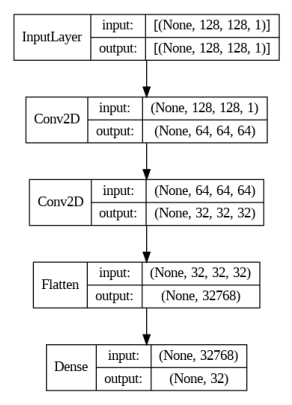

Summary of the decoder:



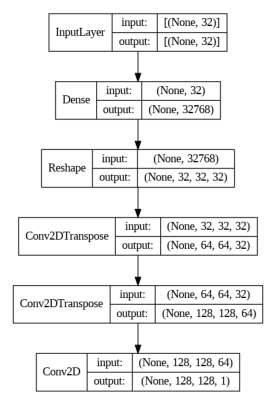

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [9]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 21s 50ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 2/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 3/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 4/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 5/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 6/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 7/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 8/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 10/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0061 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

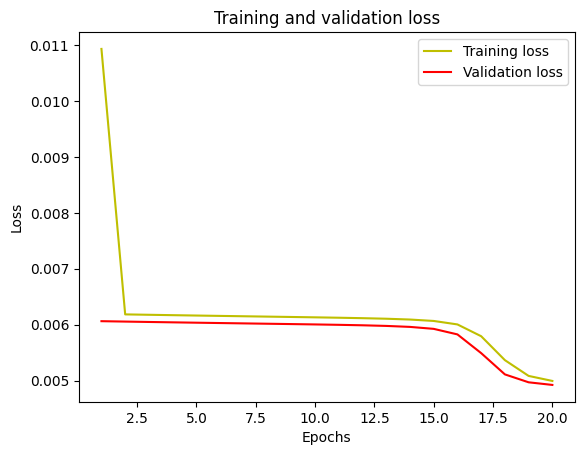

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 21ms/step


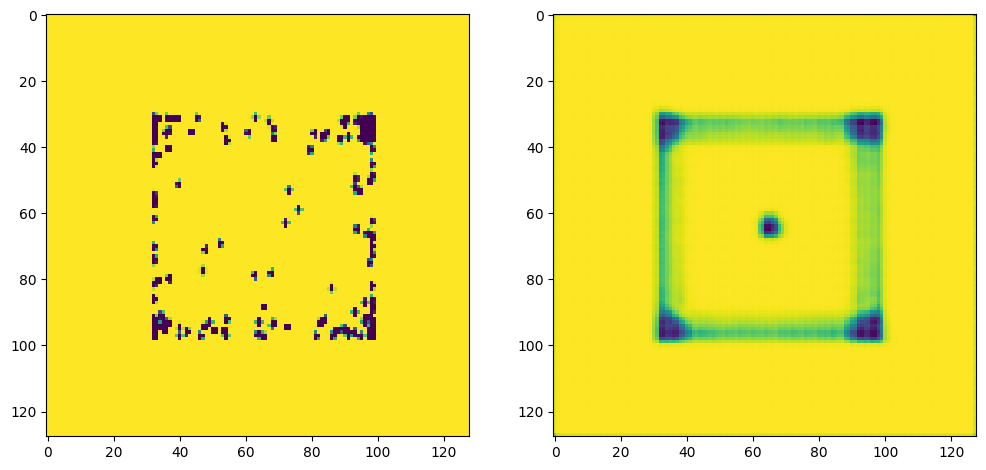

In [12]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [13]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 41ms/step - loss: 0.0180
Validation error 0.004921177867799997
Anomaly error 0.01795102097094059
The reconstruction error of the jammed channel is  3.647708222130479  more than the clean channel


In [14]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [15]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 204ms/step - loss: 0.0075


  0%|          | 1/600 [00:00<02:41,  3.71it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0012


  0%|          | 2/600 [00:00<01:48,  5.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0018


  0%|          | 3/600 [00:00<01:26,  6.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0102


  1%|          | 5/600 [00:00<01:08,  8.69it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0089


  1%|          | 6/600 [00:00<01:07,  8.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0018


  1%|▏         | 8/600 [00:00<01:00,  9.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0012


  2%|▏         | 10/600 [00:01<00:58, 10.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0074


  2%|▏         | 12/600 [00:01<01:24,  6.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


  2%|▏         | 14/600 [00:01<01:08,  8.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0074


  3%|▎         | 16/600 [00:01<00:58,  9.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0074


  3%|▎         | 18/600 [00:02<00:53, 10.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


  3%|▎         | 20/600 [00:02<00:49, 11.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


  4%|▎         | 22/600 [00:02<00:46, 12.55it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0018


  4%|▍         | 24/600 [00:02<00:46, 12.40it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0070


  4%|▍         | 26/600 [00:02<00:50, 11.35it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0093


  5%|▍         | 28/600 [00:02<00:55, 10.30it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0101


  5%|▌         | 30/600 [00:03<00:58,  9.81it/s]

1/1 [==============================] - 0s 91ms/step - loss: 0.0084


  5%|▌         | 32/600 [00:03<01:06,  8.53it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0077


  6%|▌         | 33/600 [00:03<01:09,  8.16it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0072


  6%|▌         | 34/600 [00:03<01:08,  8.30it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0093


  6%|▌         | 35/600 [00:03<01:10,  7.99it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0012


  6%|▌         | 36/600 [00:03<01:08,  8.18it/s]

1/1 [==============================] - 0s 92ms/step - loss: 0.0070


  6%|▌         | 37/600 [00:04<01:16,  7.36it/s]

1/1 [==============================] - 0s 124ms/step - loss: 0.0103


  6%|▋         | 38/600 [00:04<01:39,  5.66it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0017


  6%|▋         | 39/600 [00:04<01:30,  6.21it/s]

1/1 [==============================] - 0s 63ms/step - loss: 0.0082


  7%|▋         | 40/600 [00:04<01:33,  5.98it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0104


  7%|▋         | 41/600 [00:04<01:29,  6.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


  7%|▋         | 42/600 [00:04<01:20,  6.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


  7%|▋         | 44/600 [00:05<01:00,  9.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0013


  8%|▊         | 46/600 [00:05<00:51, 10.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0019


  8%|▊         | 48/600 [00:05<00:46, 11.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0074


  8%|▊         | 50/600 [00:05<00:42, 12.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0065


  9%|▊         | 52/600 [00:05<00:40, 13.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0082


  9%|▉         | 54/600 [00:05<00:39, 13.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


  9%|▉         | 56/600 [00:05<00:38, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0074


 10%|▉         | 58/600 [00:06<00:37, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 10%|█         | 60/600 [00:06<00:37, 14.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0100


 10%|█         | 62/600 [00:06<00:36, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0073


 11%|█         | 64/600 [00:06<00:37, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0097


 11%|█         | 66/600 [00:06<00:36, 14.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0093


 11%|█▏        | 68/600 [00:06<00:35, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0068


 12%|█▏        | 70/600 [00:06<00:35, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0090


 12%|█▏        | 72/600 [00:06<00:35, 14.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0096


 12%|█▏        | 74/600 [00:07<00:35, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0077


 13%|█▎        | 76/600 [00:07<00:35, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0070


 13%|█▎        | 78/600 [00:07<00:35, 14.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0103


 13%|█▎        | 80/600 [00:07<00:35, 14.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 14%|█▎        | 82/600 [00:07<00:36, 14.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 14%|█▍        | 84/600 [00:07<00:37, 13.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 14%|█▍        | 86/600 [00:07<00:36, 14.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 15%|█▍        | 88/600 [00:08<00:35, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0018


 15%|█▌        | 90/600 [00:08<00:33, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 15%|█▌        | 92/600 [00:08<00:35, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0075


 16%|█▌        | 94/600 [00:08<00:35, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 16%|█▌        | 96/600 [00:08<00:34, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 16%|█▋        | 98/600 [00:08<00:34, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0018


 17%|█▋        | 100/600 [00:08<00:34, 14.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0067


 17%|█▋        | 102/600 [00:09<00:34, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0017


 17%|█▋        | 104/600 [00:09<00:34, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0069


 18%|█▊        | 106/600 [00:09<00:34, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0070


 18%|█▊        | 108/600 [00:09<00:34, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0100


 18%|█▊        | 110/600 [00:09<00:35, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0016


 19%|█▊        | 112/600 [00:09<00:33, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 19%|█▉        | 114/600 [00:09<00:33, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 19%|█▉        | 116/600 [00:10<00:34, 14.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0097


 20%|█▉        | 118/600 [00:10<00:33, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 20%|██        | 120/600 [00:10<00:33, 14.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0083


 20%|██        | 122/600 [00:10<00:32, 14.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 21%|██        | 124/600 [00:10<00:32, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0099


 21%|██        | 126/600 [00:10<00:31, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0077


 21%|██▏       | 128/600 [00:10<00:31, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0073


 22%|██▏       | 130/600 [00:10<00:31, 14.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0098


 22%|██▏       | 132/600 [00:11<00:32, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 22%|██▏       | 134/600 [00:11<00:31, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0071


 23%|██▎       | 136/600 [00:11<00:30, 15.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0089


 23%|██▎       | 138/600 [00:11<00:32, 14.05it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0080


 23%|██▎       | 140/600 [00:11<00:35, 12.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 24%|██▎       | 142/600 [00:11<00:36, 12.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 24%|██▍       | 144/600 [00:12<00:36, 12.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0017


 24%|██▍       | 146/600 [00:12<00:36, 12.36it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0012


 25%|██▍       | 148/600 [00:12<00:39, 11.36it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0090


 25%|██▌       | 150/600 [00:12<00:40, 11.10it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0087


 25%|██▌       | 152/600 [00:12<00:40, 11.14it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0089


 26%|██▌       | 154/600 [00:12<00:39, 11.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0073


 26%|██▌       | 156/600 [00:13<00:40, 11.09it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0017


 26%|██▋       | 158/600 [00:13<00:40, 10.94it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0100


 27%|██▋       | 160/600 [00:13<00:40, 10.78it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0073


 27%|██▋       | 162/600 [00:13<00:40, 10.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0018


 27%|██▋       | 164/600 [00:13<00:37, 11.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0070


 28%|██▊       | 166/600 [00:14<00:34, 12.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 28%|██▊       | 168/600 [00:14<00:32, 13.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 28%|██▊       | 170/600 [00:14<00:31, 13.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 29%|██▊       | 172/600 [00:14<00:30, 13.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0097


 29%|██▉       | 174/600 [00:14<00:30, 13.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 29%|██▉       | 176/600 [00:14<00:30, 13.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0066


 30%|██▉       | 178/600 [00:14<00:28, 14.65it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0071


 30%|███       | 180/600 [00:14<00:28, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0099


 30%|███       | 182/600 [00:15<00:28, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0077


 31%|███       | 184/600 [00:15<00:28, 14.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 31%|███       | 186/600 [00:15<00:28, 14.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0083


 31%|███▏      | 188/600 [00:15<00:27, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0097


 32%|███▏      | 190/600 [00:15<00:27, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


 32%|███▏      | 192/600 [00:15<00:26, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0077


 32%|███▏      | 194/600 [00:15<00:26, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 33%|███▎      | 196/600 [00:15<00:25, 15.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0074


 33%|███▎      | 198/600 [00:16<00:26, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0071


 33%|███▎      | 200/600 [00:16<00:27, 14.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 34%|███▎      | 202/600 [00:16<00:27, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0083


 34%|███▍      | 204/600 [00:16<00:26, 14.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 34%|███▍      | 206/600 [00:16<00:26, 14.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 35%|███▍      | 208/600 [00:16<00:26, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 35%|███▌      | 210/600 [00:16<00:25, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0091


 35%|███▌      | 212/600 [00:17<00:26, 14.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0012


 36%|███▌      | 214/600 [00:17<00:26, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0073


 36%|███▌      | 216/600 [00:17<00:26, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 36%|███▋      | 218/600 [00:17<00:25, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 37%|███▋      | 220/600 [00:17<00:25, 15.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 37%|███▋      | 222/600 [00:17<00:25, 14.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0069


 37%|███▋      | 224/600 [00:17<00:25, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0075


 38%|███▊      | 226/600 [00:18<00:24, 15.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 38%|███▊      | 228/600 [00:18<00:24, 15.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0107


 38%|███▊      | 230/600 [00:18<00:24, 15.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0075


 39%|███▊      | 232/600 [00:18<00:24, 14.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0098


 39%|███▉      | 234/600 [00:18<00:23, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0093


 39%|███▉      | 236/600 [00:18<00:24, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0018


 40%|███▉      | 238/600 [00:18<00:24, 14.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0018


 40%|████      | 240/600 [00:18<00:24, 14.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 40%|████      | 242/600 [00:19<00:24, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 41%|████      | 244/600 [00:19<00:24, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 41%|████      | 246/600 [00:19<00:23, 14.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0104


 41%|████▏     | 248/600 [00:19<00:24, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 42%|████▏     | 250/600 [00:19<00:23, 14.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0076


 42%|████▏     | 252/600 [00:19<00:23, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0101


 42%|████▏     | 254/600 [00:19<00:23, 14.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 43%|████▎     | 256/600 [00:20<00:23, 14.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 43%|████▎     | 258/600 [00:20<00:23, 14.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0069


 43%|████▎     | 260/600 [00:20<00:23, 14.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0012


 44%|████▎     | 262/600 [00:20<00:23, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 44%|████▍     | 264/600 [00:20<00:23, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0091


 44%|████▍     | 266/600 [00:20<00:22, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0098


 45%|████▍     | 268/600 [00:20<00:22, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0099


 45%|████▌     | 270/600 [00:21<00:22, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0068


 45%|████▌     | 272/600 [00:21<00:23, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0108


 46%|████▌     | 274/600 [00:21<00:22, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0016


 46%|████▌     | 276/600 [00:21<00:22, 14.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0096


 46%|████▋     | 278/600 [00:21<00:22, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0018


 47%|████▋     | 280/600 [00:21<00:21, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0094


 47%|████▋     | 282/600 [00:21<00:21, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0095


 47%|████▋     | 284/600 [00:21<00:20, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 48%|████▊     | 286/600 [00:22<00:20, 15.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0095


 48%|████▊     | 288/600 [00:22<00:20, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 48%|████▊     | 290/600 [00:22<00:20, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 49%|████▊     | 292/600 [00:22<00:20, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 49%|████▉     | 294/600 [00:22<00:21, 14.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 49%|████▉     | 296/600 [00:22<00:20, 14.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 50%|████▉     | 298/600 [00:22<00:20, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 50%|█████     | 300/600 [00:23<00:19, 15.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 50%|█████     | 302/600 [00:23<00:19, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 51%|█████     | 304/600 [00:23<00:19, 15.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0076


 51%|█████     | 306/600 [00:23<00:19, 15.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0016


 51%|█████▏    | 308/600 [00:23<00:18, 15.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0074


 52%|█████▏    | 310/600 [00:23<00:18, 15.38it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


 52%|█████▏    | 312/600 [00:23<00:20, 13.98it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0017


 52%|█████▏    | 314/600 [00:24<00:21, 13.16it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0100


 53%|█████▎    | 316/600 [00:24<00:22, 12.71it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0017


 53%|█████▎    | 318/600 [00:24<00:24, 11.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0091


 53%|█████▎    | 320/600 [00:24<00:24, 11.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 54%|█████▎    | 322/600 [00:24<00:24, 11.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0094


 54%|█████▍    | 324/600 [00:24<00:23, 11.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 54%|█████▍    | 326/600 [00:25<00:24, 11.38it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0088


 55%|█████▍    | 328/600 [00:25<00:24, 11.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0090


 55%|█████▌    | 330/600 [00:25<00:24, 11.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0017


 55%|█████▌    | 332/600 [00:25<00:24, 11.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0099


 56%|█████▌    | 334/600 [00:25<00:24, 11.07it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0073


 56%|█████▌    | 336/600 [00:26<00:24, 10.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0073


 56%|█████▋    | 338/600 [00:26<00:23, 11.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0016


 57%|█████▋    | 340/600 [00:26<00:21, 11.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0106


 57%|█████▋    | 342/600 [00:26<00:20, 12.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0018


 57%|█████▋    | 344/600 [00:26<00:19, 13.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0015


 58%|█████▊    | 346/600 [00:26<00:18, 13.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 58%|█████▊    | 348/600 [00:26<00:17, 14.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0079


 58%|█████▊    | 350/600 [00:27<00:17, 14.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 59%|█████▊    | 352/600 [00:27<00:17, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 59%|█████▉    | 354/600 [00:27<00:17, 13.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 59%|█████▉    | 356/600 [00:27<00:17, 13.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0071


 60%|█████▉    | 358/600 [00:27<00:17, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 60%|██████    | 360/600 [00:27<00:17, 13.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 60%|██████    | 362/600 [00:27<00:17, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0071


 61%|██████    | 364/600 [00:28<00:16, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0099


 61%|██████    | 366/600 [00:28<00:16, 14.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0073


 61%|██████▏   | 368/600 [00:28<00:16, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


 62%|██████▏   | 370/600 [00:28<00:16, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 62%|██████▏   | 372/600 [00:28<00:16, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0071


 62%|██████▏   | 374/600 [00:28<00:16, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0075


 63%|██████▎   | 376/600 [00:28<00:16, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 63%|██████▎   | 378/600 [00:29<00:16, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0099


 63%|██████▎   | 380/600 [00:29<00:16, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0012


 64%|██████▎   | 382/600 [00:29<00:16, 13.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0077


 64%|██████▍   | 384/600 [00:29<00:16, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 64%|██████▍   | 386/600 [00:29<00:15, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0106


 65%|██████▍   | 388/600 [00:29<00:15, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0071


 65%|██████▌   | 390/600 [00:29<00:14, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 65%|██████▌   | 392/600 [00:30<00:14, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


 66%|██████▌   | 394/600 [00:30<00:14, 14.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 66%|██████▌   | 396/600 [00:30<00:14, 14.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0102


 66%|██████▋   | 398/600 [00:30<00:13, 14.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0079


 67%|██████▋   | 400/600 [00:30<00:13, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 67%|██████▋   | 402/600 [00:30<00:13, 14.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 67%|██████▋   | 404/600 [00:30<00:13, 14.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 68%|██████▊   | 406/600 [00:31<00:13, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 68%|██████▊   | 408/600 [00:31<00:13, 14.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 68%|██████▊   | 410/600 [00:31<00:13, 14.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


 69%|██████▊   | 412/600 [00:31<00:13, 14.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0113


 69%|██████▉   | 414/600 [00:31<00:12, 14.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 69%|██████▉   | 416/600 [00:31<00:12, 14.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0077


 70%|██████▉   | 418/600 [00:31<00:12, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0073


 70%|███████   | 420/600 [00:32<00:12, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 70%|███████   | 422/600 [00:32<00:11, 15.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0070


 71%|███████   | 424/600 [00:32<00:12, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 71%|███████   | 426/600 [00:32<00:11, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 71%|███████▏  | 428/600 [00:32<00:11, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0089


 72%|███████▏  | 430/600 [00:32<00:11, 14.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0076


 72%|███████▏  | 432/600 [00:32<00:11, 14.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 72%|███████▏  | 434/600 [00:33<00:12, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0017


 73%|███████▎  | 436/600 [00:33<00:11, 13.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0096


 73%|███████▎  | 438/600 [00:33<00:11, 13.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0073


 73%|███████▎  | 440/600 [00:33<00:11, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 74%|███████▎  | 442/600 [00:33<00:11, 13.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 74%|███████▍  | 444/600 [00:33<00:10, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0096


 74%|███████▍  | 446/600 [00:33<00:10, 14.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 75%|███████▍  | 448/600 [00:34<00:10, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 75%|███████▌  | 450/600 [00:34<00:10, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


 75%|███████▌  | 452/600 [00:34<00:10, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0069


 76%|███████▌  | 454/600 [00:34<00:10, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 76%|███████▌  | 456/600 [00:34<00:10, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0097


 76%|███████▋  | 458/600 [00:34<00:10, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 77%|███████▋  | 460/600 [00:34<00:10, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 77%|███████▋  | 462/600 [00:35<00:09, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0097


 77%|███████▋  | 464/600 [00:35<00:09, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0074


 78%|███████▊  | 466/600 [00:35<00:09, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 78%|███████▊  | 468/600 [00:35<00:09, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 78%|███████▊  | 470/600 [00:35<00:09, 14.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 79%|███████▊  | 472/600 [00:35<00:09, 14.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0070


 79%|███████▉  | 474/600 [00:35<00:08, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 79%|███████▉  | 476/600 [00:35<00:08, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0076


 80%|███████▉  | 478/600 [00:36<00:08, 14.40it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0073


 80%|████████  | 480/600 [00:36<00:08, 13.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0017


 80%|████████  | 482/600 [00:36<00:09, 11.98it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0012


 81%|████████  | 484/600 [00:36<00:10, 11.51it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0083


 81%|████████  | 486/600 [00:36<00:09, 11.49it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0104


 81%|████████▏ | 488/600 [00:37<00:09, 11.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0099


 82%|████████▏ | 490/600 [00:37<00:10, 10.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0079


 82%|████████▏ | 492/600 [00:37<00:10, 10.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0097


 82%|████████▏ | 494/600 [00:37<00:10, 10.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0097


 83%|████████▎ | 496/600 [00:37<00:09, 10.49it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0012


 83%|████████▎ | 498/600 [00:38<00:09, 10.47it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0012


 83%|████████▎ | 500/600 [00:38<00:09, 10.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0072


 84%|████████▎ | 502/600 [00:38<00:09,  9.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 84%|████████▍ | 504/600 [00:38<00:09, 10.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 84%|████████▍ | 506/600 [00:38<00:08, 11.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0077


 85%|████████▍ | 508/600 [00:38<00:07, 11.92it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0104


 85%|████████▌ | 510/600 [00:39<00:07, 12.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 85%|████████▌ | 512/600 [00:39<00:06, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 86%|████████▌ | 514/600 [00:39<00:06, 13.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0074


 86%|████████▌ | 516/600 [00:39<00:06, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0014


 86%|████████▋ | 518/600 [00:39<00:05, 13.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0074


 87%|████████▋ | 520/600 [00:39<00:05, 13.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 87%|████████▋ | 522/600 [00:39<00:05, 13.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0076


 87%|████████▋ | 524/600 [00:40<00:05, 13.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 88%|████████▊ | 526/600 [00:40<00:05, 14.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 88%|████████▊ | 528/600 [00:40<00:05, 14.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0097


 88%|████████▊ | 530/600 [00:40<00:05, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


 89%|████████▊ | 532/600 [00:40<00:04, 13.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


 89%|████████▉ | 534/600 [00:40<00:04, 13.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0069


 89%|████████▉ | 536/600 [00:40<00:04, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 90%|████████▉ | 538/600 [00:41<00:04, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 90%|█████████ | 540/600 [00:41<00:04, 13.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0090


 90%|█████████ | 542/600 [00:41<00:04, 13.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0017


 91%|█████████ | 544/600 [00:41<00:04, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0075


 91%|█████████ | 546/600 [00:41<00:03, 13.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0076


 91%|█████████▏| 548/600 [00:41<00:03, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0076


 92%|█████████▏| 550/600 [00:41<00:03, 13.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0016


 92%|█████████▏| 552/600 [00:42<00:03, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0104


 92%|█████████▏| 554/600 [00:42<00:03, 13.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0070


 93%|█████████▎| 556/600 [00:42<00:03, 13.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 93%|█████████▎| 558/600 [00:42<00:02, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0017


 93%|█████████▎| 560/600 [00:42<00:02, 14.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 94%|█████████▎| 562/600 [00:42<00:02, 13.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 94%|█████████▍| 564/600 [00:42<00:02, 13.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 94%|█████████▍| 566/600 [00:43<00:02, 14.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 95%|█████████▍| 568/600 [00:43<00:02, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 95%|█████████▌| 570/600 [00:43<00:02, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 95%|█████████▌| 572/600 [00:43<00:02, 13.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0075


 96%|█████████▌| 574/600 [00:43<00:01, 14.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0100


 96%|█████████▌| 576/600 [00:43<00:01, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 96%|█████████▋| 578/600 [00:43<00:01, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 97%|█████████▋| 580/600 [00:44<00:01, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 97%|█████████▋| 582/600 [00:44<00:01, 13.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 97%|█████████▋| 584/600 [00:44<00:01, 13.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0087


 98%|█████████▊| 586/600 [00:44<00:01, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0100


 98%|█████████▊| 588/600 [00:44<00:00, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 98%|█████████▊| 590/600 [00:44<00:00, 14.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 99%|█████████▊| 592/600 [00:44<00:00, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0077


 99%|█████████▉| 594/600 [00:45<00:00, 14.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0077


 99%|█████████▉| 596/600 [00:45<00:00, 13.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


100%|█████████▉| 598/600 [00:45<00:00, 13.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


  0%|          | 2/500 [00:00<00:35, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


  1%|          | 4/500 [00:00<00:35, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


  1%|          | 6/500 [00:00<00:34, 14.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


  2%|▏         | 8/500 [00:00<00:34, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


  2%|▏         | 10/500 [00:00<00:34, 14.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


  2%|▏         | 12/500 [00:00<00:35, 13.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


  3%|▎         | 14/500 [00:00<00:34, 14.23it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0175


  3%|▎         | 16/500 [00:01<00:33, 14.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


  4%|▎         | 18/500 [00:01<00:33, 14.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


  4%|▍         | 20/500 [00:01<00:33, 14.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


  4%|▍         | 22/500 [00:01<00:33, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


  5%|▍         | 24/500 [00:01<00:32, 14.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0171


  5%|▌         | 26/500 [00:01<00:32, 14.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


  6%|▌         | 28/500 [00:01<00:31, 14.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


  6%|▌         | 30/500 [00:02<00:32, 14.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


  6%|▋         | 32/500 [00:02<00:32, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


  7%|▋         | 34/500 [00:02<00:33, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0174


  7%|▋         | 36/500 [00:02<00:32, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


  8%|▊         | 38/500 [00:02<00:32, 14.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0176


  8%|▊         | 40/500 [00:02<00:33, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


  8%|▊         | 42/500 [00:02<00:32, 13.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0177


  9%|▉         | 44/500 [00:03<00:33, 13.76it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0187


  9%|▉         | 46/500 [00:03<00:36, 12.45it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0175


 10%|▉         | 48/500 [00:03<00:37, 12.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0179


 10%|█         | 50/500 [00:03<00:38, 11.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0178


 10%|█         | 52/500 [00:03<00:39, 11.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0173


 11%|█         | 54/500 [00:04<00:39, 11.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 11%|█         | 56/500 [00:04<00:39, 11.27it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0180


 12%|█▏        | 58/500 [00:04<00:40, 11.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 12%|█▏        | 60/500 [00:04<00:38, 11.40it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0179


 12%|█▏        | 62/500 [00:04<00:38, 11.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 13%|█▎        | 64/500 [00:04<00:38, 11.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0179


 13%|█▎        | 66/500 [00:05<00:39, 11.09it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0181


 14%|█▎        | 68/500 [00:05<00:40, 10.78it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0177


 14%|█▍        | 70/500 [00:05<00:40, 10.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 14%|█▍        | 72/500 [00:05<00:39, 10.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 15%|█▍        | 74/500 [00:05<00:37, 11.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 15%|█▌        | 76/500 [00:05<00:34, 12.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 16%|█▌        | 78/500 [00:06<00:33, 12.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 16%|█▌        | 80/500 [00:06<00:31, 13.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


 16%|█▋        | 82/500 [00:06<00:31, 13.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 17%|█▋        | 84/500 [00:06<00:31, 13.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 17%|█▋        | 86/500 [00:06<00:30, 13.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 18%|█▊        | 88/500 [00:06<00:29, 13.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 18%|█▊        | 90/500 [00:06<00:30, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 18%|█▊        | 92/500 [00:07<00:30, 13.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 19%|█▉        | 94/500 [00:07<00:29, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0176


 19%|█▉        | 96/500 [00:07<00:29, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 20%|█▉        | 98/500 [00:07<00:29, 13.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 20%|██        | 100/500 [00:07<00:28, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 20%|██        | 102/500 [00:07<00:28, 13.92it/s]

1/1 [==============================] - 0s 108ms/step - loss: 0.0179


 21%|██        | 104/500 [00:08<00:38, 10.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 21%|██        | 106/500 [00:08<00:43,  9.12it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0181


 22%|██▏       | 108/500 [00:08<00:38, 10.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0175


 22%|██▏       | 110/500 [00:08<00:33, 11.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0172


 22%|██▏       | 112/500 [00:08<00:32, 12.04it/s]

1/1 [==============================] - 0s 107ms/step - loss: 0.0174


 23%|██▎       | 114/500 [00:09<00:45,  8.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0178


 23%|██▎       | 116/500 [00:09<00:42,  9.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 24%|██▎       | 118/500 [00:09<00:37, 10.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0174


 24%|██▍       | 120/500 [00:09<00:33, 11.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 24%|██▍       | 122/500 [00:09<00:32, 11.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0172


 25%|██▍       | 124/500 [00:09<00:30, 12.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 25%|██▌       | 126/500 [00:10<00:29, 12.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0176


 26%|██▌       | 128/500 [00:10<00:28, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 26%|██▌       | 130/500 [00:10<00:27, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 26%|██▋       | 132/500 [00:10<00:26, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 27%|██▋       | 134/500 [00:10<00:26, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 27%|██▋       | 136/500 [00:10<00:26, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0171


 28%|██▊       | 138/500 [00:10<00:25, 13.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 28%|██▊       | 140/500 [00:11<00:26, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 28%|██▊       | 142/500 [00:11<00:26, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 29%|██▉       | 144/500 [00:11<00:25, 14.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 29%|██▉       | 146/500 [00:11<00:25, 14.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 30%|██▉       | 148/500 [00:11<00:25, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0176


 30%|███       | 150/500 [00:11<00:25, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 30%|███       | 152/500 [00:11<00:25, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 31%|███       | 154/500 [00:12<00:25, 13.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 31%|███       | 156/500 [00:12<00:25, 13.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 32%|███▏      | 158/500 [00:12<00:24, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 32%|███▏      | 160/500 [00:12<00:24, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 32%|███▏      | 162/500 [00:12<00:23, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 33%|███▎      | 164/500 [00:12<00:24, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 33%|███▎      | 166/500 [00:12<00:24, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 34%|███▎      | 168/500 [00:13<00:24, 13.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0176


 34%|███▍      | 170/500 [00:13<00:23, 13.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 34%|███▍      | 172/500 [00:13<00:23, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 35%|███▍      | 174/500 [00:13<00:22, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 35%|███▌      | 176/500 [00:13<00:23, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 36%|███▌      | 178/500 [00:13<00:23, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 36%|███▌      | 180/500 [00:14<00:24, 13.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 36%|███▋      | 182/500 [00:14<00:22, 13.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 37%|███▋      | 184/500 [00:14<00:22, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 37%|███▋      | 186/500 [00:14<00:21, 14.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0175


 38%|███▊      | 188/500 [00:14<00:22, 13.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 38%|███▊      | 190/500 [00:14<00:21, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 38%|███▊      | 192/500 [00:14<00:22, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 39%|███▉      | 194/500 [00:15<00:22, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 39%|███▉      | 196/500 [00:15<00:21, 13.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0178


 40%|███▉      | 198/500 [00:15<00:21, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 40%|████      | 200/500 [00:15<00:21, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 40%|████      | 202/500 [00:15<00:21, 13.82it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0175


 41%|████      | 204/500 [00:15<00:23, 12.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 41%|████      | 206/500 [00:15<00:25, 11.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 42%|████▏     | 208/500 [00:16<00:25, 11.29it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0175


 42%|████▏     | 210/500 [00:16<00:26, 11.11it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0184


 42%|████▏     | 212/500 [00:16<00:44,  6.52it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0183


 43%|████▎     | 213/500 [00:17<00:41,  6.89it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0177


 43%|████▎     | 214/500 [00:17<00:39,  7.19it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0180


 43%|████▎     | 215/500 [00:17<00:37,  7.63it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0182


 43%|████▎     | 217/500 [00:17<00:34,  8.31it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0182


 44%|████▎     | 218/500 [00:17<00:33,  8.36it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0180


 44%|████▍     | 219/500 [00:17<00:32,  8.65it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0178


 44%|████▍     | 220/500 [00:17<00:33,  8.45it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0180


 44%|████▍     | 221/500 [00:17<00:32,  8.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 44%|████▍     | 222/500 [00:18<00:31,  8.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 45%|████▍     | 224/500 [00:18<00:27, 10.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 45%|████▌     | 226/500 [00:18<00:25, 10.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 46%|████▌     | 228/500 [00:18<00:24, 11.17it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 46%|████▌     | 230/500 [00:18<00:23, 11.65it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 46%|████▋     | 232/500 [00:18<00:22, 12.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 47%|████▋     | 234/500 [00:19<00:22, 12.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0178


 47%|████▋     | 236/500 [00:19<00:21, 12.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 48%|████▊     | 238/500 [00:19<00:20, 12.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 48%|████▊     | 240/500 [00:19<00:20, 12.87it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0187


 48%|████▊     | 242/500 [00:19<00:20, 12.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0172


 49%|████▉     | 244/500 [00:19<00:20, 12.31it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0177


 49%|████▉     | 246/500 [00:19<00:20, 12.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0178


 50%|████▉     | 248/500 [00:20<00:21, 11.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 50%|█████     | 250/500 [00:20<00:20, 12.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 50%|█████     | 252/500 [00:20<00:19, 12.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 51%|█████     | 254/500 [00:20<00:20, 12.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0171


 51%|█████     | 256/500 [00:20<00:19, 12.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 52%|█████▏    | 258/500 [00:20<00:19, 12.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0172


 52%|█████▏    | 260/500 [00:21<00:18, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 52%|█████▏    | 262/500 [00:21<00:18, 13.04it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0171


 53%|█████▎    | 264/500 [00:21<00:18, 12.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 53%|█████▎    | 266/500 [00:21<00:18, 12.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 54%|█████▎    | 268/500 [00:21<00:18, 12.42it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0184


 54%|█████▍    | 270/500 [00:21<00:18, 12.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 54%|█████▍    | 272/500 [00:22<00:18, 12.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 55%|█████▍    | 274/500 [00:22<00:17, 12.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0176


 55%|█████▌    | 276/500 [00:22<00:17, 13.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0177


 56%|█████▌    | 278/500 [00:22<00:17, 12.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 56%|█████▌    | 280/500 [00:22<00:17, 12.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0178


 56%|█████▋    | 282/500 [00:22<00:17, 12.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 57%|█████▋    | 284/500 [00:23<00:17, 12.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 57%|█████▋    | 286/500 [00:23<00:17, 12.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 58%|█████▊    | 288/500 [00:23<00:17, 12.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 58%|█████▊    | 290/500 [00:23<00:16, 12.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


 58%|█████▊    | 292/500 [00:23<00:15, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 59%|█████▉    | 294/500 [00:23<00:16, 12.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0178


 59%|█████▉    | 296/500 [00:23<00:15, 12.95it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0180


 60%|█████▉    | 298/500 [00:24<00:15, 13.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 60%|██████    | 300/500 [00:24<00:14, 13.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0174


 60%|██████    | 302/500 [00:24<00:14, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 61%|██████    | 304/500 [00:24<00:14, 13.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 61%|██████    | 306/500 [00:24<00:14, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 62%|██████▏   | 308/500 [00:24<00:14, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 62%|██████▏   | 310/500 [00:24<00:13, 13.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 62%|██████▏   | 312/500 [00:25<00:13, 13.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 63%|██████▎   | 314/500 [00:25<00:13, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 63%|██████▎   | 316/500 [00:25<00:13, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 64%|██████▎   | 318/500 [00:25<00:13, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 64%|██████▍   | 320/500 [00:25<00:13, 13.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 64%|██████▍   | 322/500 [00:25<00:13, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 65%|██████▍   | 324/500 [00:25<00:12, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 65%|██████▌   | 326/500 [00:26<00:13, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 66%|██████▌   | 328/500 [00:26<00:12, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 66%|██████▌   | 330/500 [00:26<00:12, 14.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 66%|██████▋   | 332/500 [00:26<00:11, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 67%|██████▋   | 334/500 [00:26<00:11, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 67%|██████▋   | 336/500 [00:26<00:11, 13.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0178


 68%|██████▊   | 338/500 [00:26<00:11, 14.18it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0178


 68%|██████▊   | 340/500 [00:27<00:11, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0172


 68%|██████▊   | 342/500 [00:27<00:11, 14.30it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0177


 69%|██████▉   | 344/500 [00:27<00:10, 14.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 69%|██████▉   | 346/500 [00:27<00:10, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 70%|██████▉   | 348/500 [00:27<00:10, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 70%|███████   | 350/500 [00:27<00:10, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 70%|███████   | 352/500 [00:27<00:10, 13.79it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0181


 71%|███████   | 354/500 [00:28<00:11, 12.76it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0175


 71%|███████   | 356/500 [00:28<00:11, 12.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0182


 72%|███████▏  | 358/500 [00:28<00:12, 11.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 72%|███████▏  | 360/500 [00:28<00:12, 11.45it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0179


 72%|███████▏  | 362/500 [00:28<00:11, 11.51it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0179


 73%|███████▎  | 364/500 [00:29<00:12, 11.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 73%|███████▎  | 366/500 [00:29<00:11, 11.29it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0185


 74%|███████▎  | 368/500 [00:29<00:11, 11.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 74%|███████▍  | 370/500 [00:29<00:11, 10.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0186


 74%|███████▍  | 372/500 [00:29<00:11, 10.77it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0182


 75%|███████▍  | 374/500 [00:29<00:11, 10.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 75%|███████▌  | 376/500 [00:30<00:11, 10.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0182


 76%|███████▌  | 378/500 [00:30<00:11, 10.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0180


 76%|███████▌  | 380/500 [00:30<00:11, 10.38it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0179


 76%|███████▋  | 382/500 [00:30<00:11, 10.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 77%|███████▋  | 384/500 [00:30<00:10, 11.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0173


 77%|███████▋  | 386/500 [00:31<00:09, 11.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 78%|███████▊  | 388/500 [00:31<00:09, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 78%|███████▊  | 390/500 [00:31<00:08, 12.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 78%|███████▊  | 392/500 [00:31<00:08, 12.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 79%|███████▉  | 394/500 [00:31<00:08, 12.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 79%|███████▉  | 396/500 [00:31<00:07, 13.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 80%|███████▉  | 398/500 [00:31<00:07, 13.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 80%|████████  | 400/500 [00:32<00:07, 12.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 80%|████████  | 402/500 [00:32<00:07, 12.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 81%|████████  | 404/500 [00:32<00:07, 13.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 81%|████████  | 406/500 [00:32<00:06, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 82%|████████▏ | 408/500 [00:32<00:07, 13.05it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0174


 82%|████████▏ | 410/500 [00:32<00:06, 13.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 82%|████████▏ | 412/500 [00:33<00:06, 13.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


 83%|████████▎ | 414/500 [00:33<00:06, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 83%|████████▎ | 416/500 [00:33<00:06, 13.57it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0175


 84%|████████▎ | 418/500 [00:33<00:06, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 84%|████████▍ | 420/500 [00:33<00:05, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 84%|████████▍ | 422/500 [00:33<00:05, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0189


 85%|████████▍ | 424/500 [00:33<00:05, 13.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 85%|████████▌ | 426/500 [00:34<00:05, 13.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0177


 86%|████████▌ | 428/500 [00:34<00:05, 13.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 86%|████████▌ | 430/500 [00:34<00:05, 13.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 86%|████████▋ | 432/500 [00:34<00:05, 13.42it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0187


 87%|████████▋ | 434/500 [00:34<00:04, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 87%|████████▋ | 436/500 [00:34<00:04, 13.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 88%|████████▊ | 438/500 [00:34<00:04, 13.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 88%|████████▊ | 440/500 [00:35<00:04, 13.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 88%|████████▊ | 442/500 [00:35<00:04, 13.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 89%|████████▉ | 444/500 [00:35<00:04, 13.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 89%|████████▉ | 446/500 [00:35<00:03, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 90%|████████▉ | 448/500 [00:35<00:03, 13.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 90%|█████████ | 450/500 [00:35<00:03, 13.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 90%|█████████ | 452/500 [00:35<00:03, 13.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0177


 91%|█████████ | 454/500 [00:36<00:03, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 91%|█████████ | 456/500 [00:36<00:03, 13.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 92%|█████████▏| 458/500 [00:36<00:03, 13.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 92%|█████████▏| 460/500 [00:36<00:03, 13.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 92%|█████████▏| 462/500 [00:36<00:02, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 93%|█████████▎| 464/500 [00:36<00:02, 13.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0175


 93%|█████████▎| 466/500 [00:37<00:02, 13.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 94%|█████████▎| 468/500 [00:37<00:02, 13.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0169


 94%|█████████▍| 470/500 [00:37<00:02, 13.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 94%|█████████▍| 472/500 [00:37<00:02, 13.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0174


 95%|█████████▍| 474/500 [00:37<00:01, 13.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 95%|█████████▌| 476/500 [00:37<00:01, 13.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 96%|█████████▌| 478/500 [00:37<00:01, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0173


 96%|█████████▌| 480/500 [00:38<00:01, 13.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0176


 96%|█████████▋| 482/500 [00:38<00:01, 13.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 97%|█████████▋| 484/500 [00:38<00:01, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0174


 97%|█████████▋| 486/500 [00:38<00:01, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 98%|█████████▊| 488/500 [00:38<00:00, 14.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 98%|█████████▊| 490/500 [00:38<00:00, 14.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0172


 98%|█████████▊| 492/500 [00:38<00:00, 14.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 99%|█████████▉| 494/500 [00:39<00:00, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 99%|█████████▉| 496/500 [00:39<00:00, 13.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


100%|█████████▉| 498/500 [00:39<00:00, 14.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0175


100%|██████████| 500/500 [00:39<00:00, 12.66it/s]


In [16]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.004921177425421775 
Standard deviation of the reconstruction error of the clean channel: 0.003666451665545466
Mean of the reconstruction error of the jammed channel: 0.01795102073252201 
Standard deviation of the reconstruction error of the jammed channel: 0.00038645418729774274


In [17]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


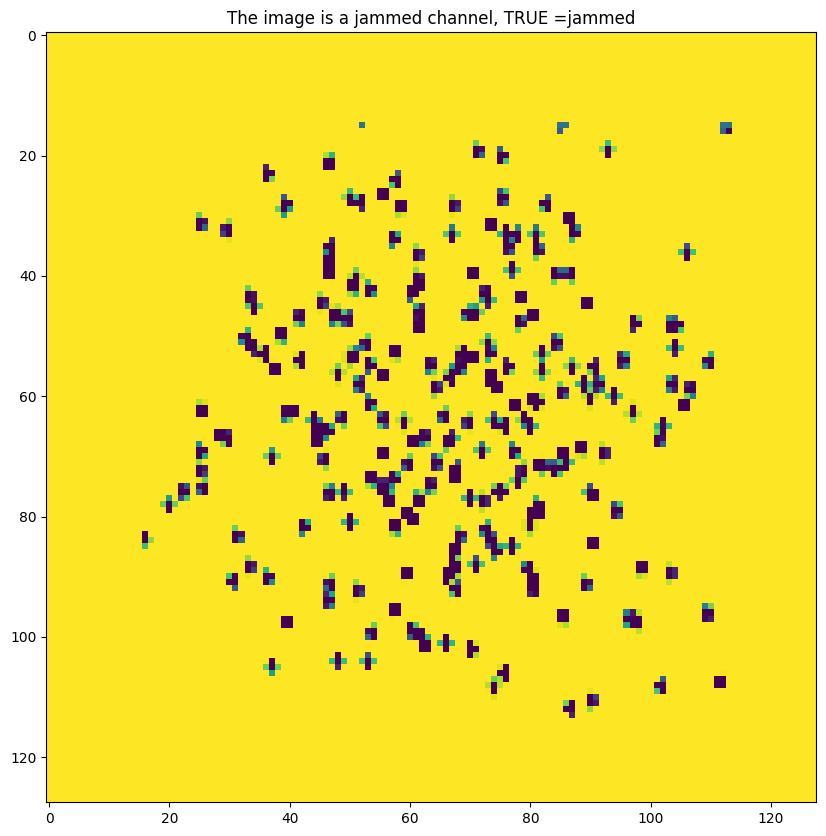

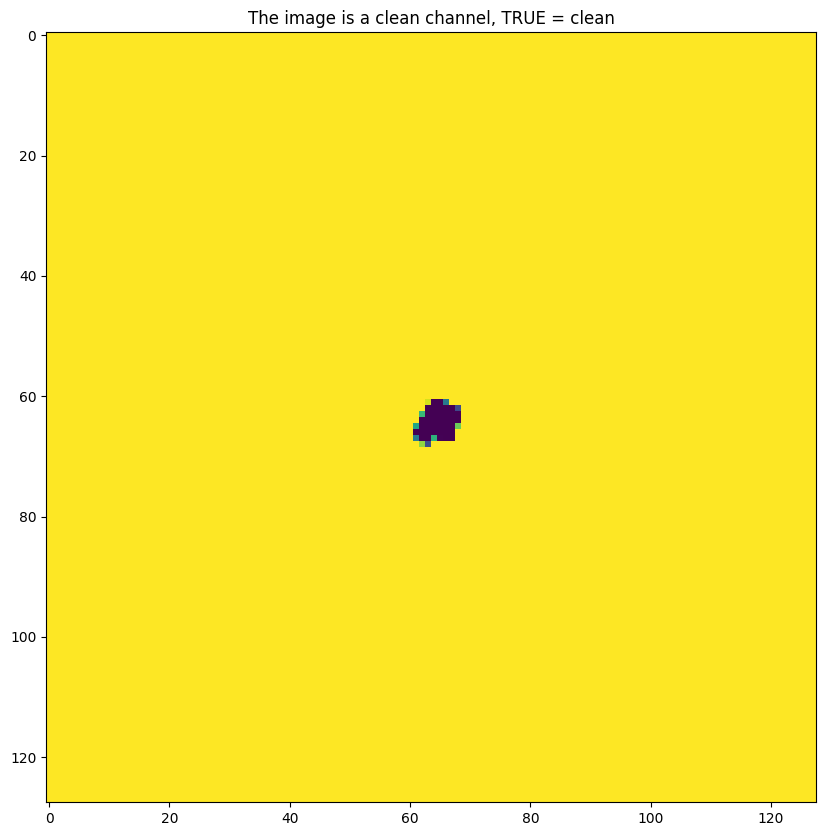

In [18]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [19]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [20]:
values_th=np.arange(normal_values[0],jammed_values[0],0.0005)
print(len(values_th))

27


In [21]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  0%|          | 2/800 [00:00<00:59, 13.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0092


  0%|          | 4/800 [00:00<00:56, 14.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


  1%|          | 6/800 [00:00<00:52, 15.27it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0079


  1%|          | 8/800 [00:00<00:52, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


  1%|▏         | 10/800 [00:00<00:52, 14.91it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0181


  2%|▏         | 12/800 [00:00<00:50, 15.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


  2%|▏         | 14/800 [00:00<00:50, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


  2%|▏         | 16/800 [00:01<00:50, 15.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


  2%|▏         | 18/800 [00:01<00:50, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


  2%|▎         | 20/800 [00:01<00:48, 16.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0086


  3%|▎         | 22/800 [00:01<00:46, 16.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0092


  3%|▎         | 24/800 [00:01<00:45, 17.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0172


  3%|▎         | 26/800 [00:01<00:45, 17.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


  4%|▎         | 28/800 [00:01<00:44, 17.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


  4%|▍         | 30/800 [00:01<00:44, 17.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


  4%|▍         | 32/800 [00:01<00:45, 16.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


  4%|▍         | 34/800 [00:02<00:46, 16.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0018


  4%|▍         | 36/800 [00:02<00:49, 15.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0175


  5%|▍         | 38/800 [00:02<00:49, 15.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


  5%|▌         | 40/800 [00:02<00:47, 16.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0087


  5%|▌         | 42/800 [00:02<00:46, 16.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


  6%|▌         | 44/800 [00:02<00:45, 16.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


  6%|▌         | 46/800 [00:02<00:46, 16.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


  6%|▌         | 48/800 [00:02<00:46, 16.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0082


  6%|▋         | 50/800 [00:03<00:46, 15.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


  6%|▋         | 52/800 [00:03<00:48, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


  7%|▋         | 54/800 [00:03<00:46, 16.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


  7%|▋         | 56/800 [00:03<00:45, 16.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


  7%|▋         | 58/800 [00:03<00:44, 16.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0176


  8%|▊         | 60/800 [00:03<00:43, 16.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


  8%|▊         | 62/800 [00:03<00:43, 16.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0017


  8%|▊         | 64/800 [00:03<00:45, 16.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


  8%|▊         | 66/800 [00:04<00:47, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0086


  8%|▊         | 68/800 [00:04<00:46, 15.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0085


  9%|▉         | 70/800 [00:04<00:46, 15.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


  9%|▉         | 72/800 [00:04<00:45, 15.83it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0180


  9%|▉         | 74/800 [00:04<00:45, 16.09it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 10%|▉         | 76/800 [00:04<00:45, 15.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 10%|▉         | 78/800 [00:04<00:46, 15.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 10%|█         | 80/800 [00:05<00:45, 15.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0080


 10%|█         | 82/800 [00:05<00:43, 16.37it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0178


 10%|█         | 84/800 [00:05<00:44, 16.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0080


 11%|█         | 86/800 [00:05<00:46, 15.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0012


 11%|█         | 88/800 [00:05<00:50, 14.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0177


 11%|█▏        | 90/800 [00:05<00:53, 13.37it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0016


 12%|█▏        | 92/800 [00:05<00:55, 12.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 12%|█▏        | 94/800 [00:06<00:57, 12.21it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0185


 12%|█▏        | 96/800 [00:06<00:59, 11.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 12%|█▏        | 98/800 [00:06<00:59, 11.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0090


 12%|█▎        | 100/800 [00:06<00:59, 11.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0084


 13%|█▎        | 102/800 [00:06<00:59, 11.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0088


 13%|█▎        | 104/800 [00:06<00:59, 11.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0089


 13%|█▎        | 106/800 [00:07<00:59, 11.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0012


 14%|█▎        | 108/800 [00:07<00:59, 11.63it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0182


 14%|█▍        | 110/800 [00:07<00:58, 11.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 14%|█▍        | 112/800 [00:07<00:54, 12.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 14%|█▍        | 114/800 [00:07<00:50, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0018


 14%|█▍        | 116/800 [00:07<00:48, 14.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0074


 15%|█▍        | 118/800 [00:07<00:45, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0018


 15%|█▌        | 120/800 [00:08<00:44, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 15%|█▌        | 122/800 [00:08<00:44, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 16%|█▌        | 124/800 [00:08<00:43, 15.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 16%|█▌        | 126/800 [00:08<00:43, 15.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 16%|█▌        | 128/800 [00:08<00:44, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0172


 16%|█▋        | 130/800 [00:08<00:44, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 16%|█▋        | 132/800 [00:08<00:45, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 17%|█▋        | 134/800 [00:09<00:45, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


 17%|█▋        | 136/800 [00:09<00:42, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 17%|█▋        | 138/800 [00:09<00:41, 15.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 18%|█▊        | 140/800 [00:09<00:41, 15.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


 18%|█▊        | 142/800 [00:09<00:41, 15.84it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0177


 18%|█▊        | 144/800 [00:09<00:41, 15.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0081


 18%|█▊        | 146/800 [00:09<00:41, 15.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0087


 18%|█▊        | 148/800 [00:09<00:42, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0188


 19%|█▉        | 150/800 [00:10<00:40, 15.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 19%|█▉        | 152/800 [00:10<00:40, 16.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 19%|█▉        | 154/800 [00:10<00:39, 16.43it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0018


 20%|█▉        | 156/800 [00:10<00:39, 16.11it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 20%|█▉        | 158/800 [00:10<00:41, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 20%|██        | 160/800 [00:10<00:40, 15.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0081


 20%|██        | 162/800 [00:10<00:41, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0018


 20%|██        | 164/800 [00:10<00:42, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 21%|██        | 166/800 [00:11<00:40, 15.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0087


 21%|██        | 168/800 [00:11<00:39, 16.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0018


 21%|██▏       | 170/800 [00:11<00:38, 16.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 22%|██▏       | 172/800 [00:11<00:38, 16.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0089


 22%|██▏       | 174/800 [00:11<00:38, 16.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 22%|██▏       | 176/800 [00:11<00:39, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 22%|██▏       | 178/800 [00:11<00:41, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 22%|██▎       | 180/800 [00:11<00:39, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0174


 23%|██▎       | 182/800 [00:12<00:39, 15.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 23%|██▎       | 184/800 [00:12<00:38, 16.10it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0078


 23%|██▎       | 186/800 [00:12<00:36, 16.60it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0085


 24%|██▎       | 188/800 [00:12<00:38, 15.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0175


 24%|██▍       | 190/800 [00:12<00:37, 16.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 24%|██▍       | 192/800 [00:12<00:38, 15.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0174


 24%|██▍       | 194/800 [00:12<00:38, 15.82it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0174


 24%|██▍       | 196/800 [00:12<00:37, 16.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


 25%|██▍       | 198/800 [00:13<00:37, 16.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 25%|██▌       | 200/800 [00:13<00:38, 15.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0174


 25%|██▌       | 202/800 [00:13<00:37, 15.97it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0017


 26%|██▌       | 204/800 [00:13<00:37, 15.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 26%|██▌       | 206/800 [00:13<00:38, 15.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0167


 26%|██▌       | 208/800 [00:13<00:37, 15.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0172


 26%|██▋       | 210/800 [00:13<00:37, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 26%|██▋       | 212/800 [00:13<00:37, 15.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 27%|██▋       | 214/800 [00:14<00:36, 15.93it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0086


 27%|██▋       | 216/800 [00:14<00:36, 16.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0176


 27%|██▋       | 218/800 [00:14<00:36, 15.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0086


 28%|██▊       | 220/800 [00:14<00:37, 15.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0084


 28%|██▊       | 222/800 [00:14<00:38, 14.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0017


 28%|██▊       | 224/800 [00:14<00:39, 14.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 28%|██▊       | 226/800 [00:14<00:38, 15.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0092


 28%|██▊       | 228/800 [00:14<00:38, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 29%|██▉       | 230/800 [00:15<00:36, 15.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0174


 29%|██▉       | 232/800 [00:15<00:36, 15.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 29%|██▉       | 234/800 [00:15<00:36, 15.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 30%|██▉       | 236/800 [00:15<00:36, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 30%|██▉       | 238/800 [00:15<00:36, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0174


 30%|███       | 240/800 [00:15<00:36, 15.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 30%|███       | 242/800 [00:15<00:36, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0081


 30%|███       | 244/800 [00:16<00:36, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0083


 31%|███       | 246/800 [00:16<00:35, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


 31%|███       | 248/800 [00:16<00:34, 15.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0088


 31%|███▏      | 250/800 [00:16<00:35, 15.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 32%|███▏      | 252/800 [00:16<00:35, 15.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 32%|███▏      | 254/800 [00:16<00:35, 15.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 32%|███▏      | 256/800 [00:16<00:35, 15.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 32%|███▏      | 258/800 [00:16<00:34, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 32%|███▎      | 260/800 [00:17<00:34, 15.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0086


 33%|███▎      | 262/800 [00:17<00:35, 15.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0082


 33%|███▎      | 264/800 [00:17<00:34, 15.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 33%|███▎      | 266/800 [00:17<00:33, 16.02it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 34%|███▎      | 268/800 [00:17<00:34, 15.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 34%|███▍      | 270/800 [00:17<00:39, 13.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 34%|███▍      | 272/800 [00:17<00:40, 13.04it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0078


 34%|███▍      | 274/800 [00:18<00:41, 12.67it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0016


 34%|███▍      | 276/800 [00:18<00:42, 12.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0178


 35%|███▍      | 278/800 [00:18<00:42, 12.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 35%|███▌      | 280/800 [00:18<00:44, 11.76it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0180


 35%|███▌      | 282/800 [00:18<00:44, 11.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 36%|███▌      | 284/800 [00:18<00:44, 11.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 36%|███▌      | 286/800 [00:19<00:44, 11.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 36%|███▌      | 288/800 [00:19<00:43, 11.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0017


 36%|███▋      | 290/800 [00:19<00:44, 11.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0087


 36%|███▋      | 292/800 [00:19<00:45, 11.19it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0179


 37%|███▋      | 294/800 [00:19<00:44, 11.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 37%|███▋      | 296/800 [00:19<00:40, 12.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 37%|███▋      | 298/800 [00:20<00:39, 12.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 38%|███▊      | 300/800 [00:20<00:36, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 38%|███▊      | 302/800 [00:20<00:34, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 38%|███▊      | 304/800 [00:20<00:34, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 38%|███▊      | 306/800 [00:20<00:34, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 38%|███▊      | 308/800 [00:20<00:34, 14.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 39%|███▉      | 310/800 [00:20<00:33, 14.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 39%|███▉      | 312/800 [00:21<00:32, 14.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 39%|███▉      | 314/800 [00:21<00:33, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0173


 40%|███▉      | 316/800 [00:21<00:32, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 40%|███▉      | 318/800 [00:21<00:32, 14.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0177


 40%|████      | 320/800 [00:21<00:32, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 40%|████      | 322/800 [00:21<00:32, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 40%|████      | 324/800 [00:21<00:32, 14.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0176


 41%|████      | 326/800 [00:21<00:31, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 41%|████      | 328/800 [00:22<00:31, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 41%|████▏     | 330/800 [00:22<00:31, 15.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 42%|████▏     | 332/800 [00:22<00:31, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 42%|████▏     | 334/800 [00:22<00:32, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 42%|████▏     | 336/800 [00:22<00:31, 14.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0067


 42%|████▏     | 338/800 [00:22<00:31, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 42%|████▎     | 340/800 [00:22<00:31, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 43%|████▎     | 342/800 [00:23<00:31, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0091


 43%|████▎     | 344/800 [00:23<00:30, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0083


 43%|████▎     | 346/800 [00:23<00:29, 15.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0085


 44%|████▎     | 348/800 [00:23<00:30, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 44%|████▍     | 350/800 [00:23<00:30, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 44%|████▍     | 352/800 [00:23<00:29, 15.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


 44%|████▍     | 354/800 [00:23<00:28, 15.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0016


 44%|████▍     | 356/800 [00:23<00:29, 15.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 45%|████▍     | 358/800 [00:24<00:29, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 45%|████▌     | 360/800 [00:24<00:29, 15.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 45%|████▌     | 362/800 [00:24<00:29, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 46%|████▌     | 364/800 [00:24<00:29, 14.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 46%|████▌     | 366/800 [00:24<00:30, 14.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0082


 46%|████▌     | 368/800 [00:24<00:30, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0087


 46%|████▋     | 370/800 [00:24<00:29, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 46%|████▋     | 372/800 [00:25<00:28, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0017


 47%|████▋     | 374/800 [00:25<00:28, 14.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0178


 47%|████▋     | 376/800 [00:25<00:29, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


 47%|████▋     | 378/800 [00:25<00:30, 13.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 48%|████▊     | 380/800 [00:25<00:29, 14.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 48%|████▊     | 382/800 [00:25<00:29, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


 48%|████▊     | 384/800 [00:25<00:29, 14.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0172


 48%|████▊     | 386/800 [00:26<00:28, 14.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 48%|████▊     | 388/800 [00:26<00:27, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 49%|████▉     | 390/800 [00:26<00:27, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 49%|████▉     | 392/800 [00:26<00:28, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


 49%|████▉     | 394/800 [00:26<00:28, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0084


 50%|████▉     | 396/800 [00:26<00:27, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 50%|████▉     | 398/800 [00:26<00:27, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 50%|█████     | 400/800 [00:27<00:26, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0084


 50%|█████     | 402/800 [00:27<00:26, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 50%|█████     | 404/800 [00:27<00:26, 15.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0174


 51%|█████     | 406/800 [00:27<00:25, 15.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 51%|█████     | 408/800 [00:27<00:25, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0091


 51%|█████▏    | 410/800 [00:27<00:26, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 52%|█████▏    | 412/800 [00:27<00:25, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0085


 52%|█████▏    | 414/800 [00:27<00:25, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0017


 52%|█████▏    | 416/800 [00:28<00:25, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 52%|█████▏    | 418/800 [00:28<00:25, 15.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 52%|█████▎    | 420/800 [00:28<00:24, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 53%|█████▎    | 422/800 [00:28<00:25, 15.06it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0186


 53%|█████▎    | 424/800 [00:28<00:24, 15.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 53%|█████▎    | 426/800 [00:28<00:24, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0081


 54%|█████▎    | 428/800 [00:28<00:24, 15.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0094


 54%|█████▍    | 430/800 [00:28<00:24, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 54%|█████▍    | 432/800 [00:29<00:24, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 54%|█████▍    | 434/800 [00:29<00:24, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 55%|█████▍    | 436/800 [00:29<00:23, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 55%|█████▍    | 438/800 [00:29<00:23, 15.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0017


 55%|█████▌    | 440/800 [00:29<00:23, 15.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 55%|█████▌    | 442/800 [00:29<00:23, 15.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 56%|█████▌    | 444/800 [00:29<00:24, 14.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0082


 56%|█████▌    | 446/800 [00:30<00:26, 13.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0016


 56%|█████▌    | 448/800 [00:30<00:27, 12.88it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0084


 56%|█████▋    | 450/800 [00:30<00:27, 12.61it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0085


 56%|█████▋    | 452/800 [00:30<00:27, 12.55it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0080


 57%|█████▋    | 454/800 [00:30<00:28, 12.06it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0177


 57%|█████▋    | 456/800 [00:30<00:29, 11.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0178


 57%|█████▋    | 458/800 [00:31<00:29, 11.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 57%|█████▊    | 460/800 [00:31<00:29, 11.48it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0180


 58%|█████▊    | 462/800 [00:31<00:29, 11.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 58%|█████▊    | 464/800 [00:31<00:29, 11.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 58%|█████▊    | 466/800 [00:31<00:29, 11.24it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0178


 58%|█████▊    | 468/800 [00:32<00:30, 11.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0087


 59%|█████▉    | 470/800 [00:32<00:30, 10.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0171


 59%|█████▉    | 472/800 [00:32<00:29, 11.27it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


 59%|█████▉    | 474/800 [00:32<00:26, 12.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0085


 60%|█████▉    | 476/800 [00:32<00:25, 12.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0017


 60%|█████▉    | 478/800 [00:32<00:23, 13.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 60%|██████    | 480/800 [00:32<00:24, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0084


 60%|██████    | 482/800 [00:33<00:23, 13.68it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0176


 60%|██████    | 484/800 [00:33<00:22, 14.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0087


 61%|██████    | 486/800 [00:33<00:21, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 61%|██████    | 488/800 [00:33<00:21, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 61%|██████▏   | 490/800 [00:33<00:21, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0082


 62%|██████▏   | 492/800 [00:33<00:20, 14.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0089


 62%|██████▏   | 494/800 [00:33<00:20, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 62%|██████▏   | 496/800 [00:34<00:20, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 62%|██████▏   | 498/800 [00:34<00:20, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 62%|██████▎   | 500/800 [00:34<00:20, 14.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 63%|██████▎   | 502/800 [00:34<00:20, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 63%|██████▎   | 504/800 [00:34<00:20, 14.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 63%|██████▎   | 506/800 [00:34<00:20, 14.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0086


 64%|██████▎   | 508/800 [00:34<00:19, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0017


 64%|██████▍   | 510/800 [00:34<00:19, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 64%|██████▍   | 512/800 [00:35<00:19, 14.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 64%|██████▍   | 514/800 [00:35<00:19, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 64%|██████▍   | 516/800 [00:35<00:18, 15.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0078


 65%|██████▍   | 518/800 [00:35<00:19, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 65%|██████▌   | 520/800 [00:35<00:18, 15.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0080


 65%|██████▌   | 522/800 [00:35<00:18, 15.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0016


 66%|██████▌   | 524/800 [00:36<00:32,  8.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0083


 66%|██████▌   | 526/800 [00:36<00:28,  9.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0090


 66%|██████▌   | 528/800 [00:36<00:25, 10.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0087


 66%|██████▋   | 530/800 [00:36<00:23, 11.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0172


 66%|██████▋   | 532/800 [00:36<00:22, 11.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 67%|██████▋   | 534/800 [00:36<00:21, 12.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 67%|██████▋   | 536/800 [00:37<00:20, 12.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 67%|██████▋   | 538/800 [00:37<00:19, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0172


 68%|██████▊   | 540/800 [00:37<00:19, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 68%|██████▊   | 542/800 [00:37<00:19, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0096


 68%|██████▊   | 544/800 [00:37<00:19, 13.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 68%|██████▊   | 546/800 [00:37<00:19, 13.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0080


 68%|██████▊   | 548/800 [00:38<00:19, 13.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0089


 69%|██████▉   | 550/800 [00:38<00:19, 13.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0091


 69%|██████▉   | 552/800 [00:38<00:18, 13.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0175


 69%|██████▉   | 554/800 [00:38<00:18, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0085


 70%|██████▉   | 556/800 [00:38<00:18, 13.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0017


 70%|██████▉   | 558/800 [00:38<00:18, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 70%|███████   | 560/800 [00:38<00:17, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0012


 70%|███████   | 562/800 [00:39<00:17, 13.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0090


 70%|███████   | 564/800 [00:39<00:17, 13.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 71%|███████   | 566/800 [00:39<00:17, 13.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0018


 71%|███████   | 568/800 [00:39<00:17, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0084


 71%|███████▏  | 570/800 [00:39<00:17, 13.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 72%|███████▏  | 572/800 [00:39<00:16, 13.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 72%|███████▏  | 574/800 [00:39<00:16, 13.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0088


 72%|███████▏  | 576/800 [00:40<00:16, 13.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0158


 72%|███████▏  | 578/800 [00:40<00:16, 13.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0084


 72%|███████▎  | 580/800 [00:40<00:16, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 73%|███████▎  | 582/800 [00:40<00:16, 13.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 73%|███████▎  | 584/800 [00:40<00:16, 13.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0178


 73%|███████▎  | 586/800 [00:40<00:16, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0083


 74%|███████▎  | 588/800 [00:41<00:16, 12.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0177


 74%|███████▍  | 590/800 [00:41<00:15, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0093


 74%|███████▍  | 592/800 [00:41<00:15, 13.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 74%|███████▍  | 594/800 [00:41<00:15, 13.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 74%|███████▍  | 596/800 [00:41<00:14, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0017


 75%|███████▍  | 598/800 [00:41<00:14, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 75%|███████▌  | 600/800 [00:41<00:14, 14.20it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0012


 75%|███████▌  | 602/800 [00:42<00:13, 14.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0089


 76%|███████▌  | 604/800 [00:42<00:14, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0087


 76%|███████▌  | 606/800 [00:42<00:14, 13.85it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0178


 76%|███████▌  | 608/800 [00:42<00:15, 12.45it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0017


 76%|███████▋  | 610/800 [00:42<00:16, 11.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0082


 76%|███████▋  | 612/800 [00:42<00:16, 11.59it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0178


 77%|███████▋  | 614/800 [00:43<00:16, 11.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 77%|███████▋  | 616/800 [00:43<00:16, 11.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 77%|███████▋  | 618/800 [00:43<00:16, 11.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 78%|███████▊  | 620/800 [00:43<00:16, 11.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 78%|███████▊  | 622/800 [00:43<00:15, 11.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0087


 78%|███████▊  | 624/800 [00:43<00:16, 10.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0012


 78%|███████▊  | 626/800 [00:44<00:15, 10.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0185


 78%|███████▊  | 628/800 [00:44<00:15, 10.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 79%|███████▉  | 630/800 [00:44<00:15, 10.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0091


 79%|███████▉  | 632/800 [00:44<00:16, 10.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 79%|███████▉  | 634/800 [00:44<00:14, 11.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0085


 80%|███████▉  | 636/800 [00:44<00:12, 12.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0084


 80%|███████▉  | 638/800 [00:45<00:12, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 80%|████████  | 640/800 [00:45<00:11, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0090


 80%|████████  | 642/800 [00:45<00:11, 13.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 80%|████████  | 644/800 [00:45<00:11, 14.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 81%|████████  | 646/800 [00:45<00:10, 14.74it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0012


 81%|████████  | 648/800 [00:45<00:09, 15.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0173


 81%|████████▏ | 650/800 [00:45<00:09, 15.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 82%|████████▏ | 652/800 [00:46<00:09, 15.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0082


 82%|████████▏ | 654/800 [00:46<00:09, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0094


 82%|████████▏ | 656/800 [00:46<00:09, 14.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0172


 82%|████████▏ | 658/800 [00:46<00:09, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 82%|████████▎ | 660/800 [00:46<00:09, 14.87it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0179


 83%|████████▎ | 662/800 [00:46<00:09, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 83%|████████▎ | 664/800 [00:46<00:08, 15.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0137


 83%|████████▎ | 666/800 [00:46<00:08, 15.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0089


 84%|████████▎ | 668/800 [00:47<00:08, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0018


 84%|████████▍ | 670/800 [00:47<00:08, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 84%|████████▍ | 672/800 [00:47<00:08, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 84%|████████▍ | 674/800 [00:47<00:08, 15.09it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0017


 84%|████████▍ | 676/800 [00:47<00:08, 15.17it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0083


 85%|████████▍ | 678/800 [00:47<00:08, 15.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0089


 85%|████████▌ | 680/800 [00:47<00:07, 15.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 85%|████████▌ | 682/800 [00:48<00:07, 15.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0081


 86%|████████▌ | 684/800 [00:48<00:07, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 86%|████████▌ | 686/800 [00:48<00:07, 15.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0016


 86%|████████▌ | 688/800 [00:48<00:07, 14.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0083


 86%|████████▋ | 690/800 [00:48<00:07, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 86%|████████▋ | 692/800 [00:48<00:07, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0085


 87%|████████▋ | 694/800 [00:48<00:06, 15.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


 87%|████████▋ | 696/800 [00:48<00:06, 15.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 87%|████████▋ | 698/800 [00:49<00:06, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


 88%|████████▊ | 700/800 [00:49<00:06, 14.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0171


 88%|████████▊ | 702/800 [00:49<00:06, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 88%|████████▊ | 704/800 [00:49<00:06, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 88%|████████▊ | 706/800 [00:49<00:06, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 88%|████████▊ | 708/800 [00:49<00:06, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0089


 89%|████████▉ | 710/800 [00:49<00:06, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 89%|████████▉ | 712/800 [00:50<00:05, 14.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 89%|████████▉ | 714/800 [00:50<00:05, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 90%|████████▉ | 716/800 [00:50<00:05, 14.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 90%|████████▉ | 718/800 [00:50<00:05, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0172


 90%|█████████ | 720/800 [00:50<00:05, 14.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 90%|█████████ | 722/800 [00:50<00:05, 14.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 90%|█████████ | 724/800 [00:50<00:05, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0084


 91%|█████████ | 726/800 [00:51<00:05, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 91%|█████████ | 728/800 [00:51<00:04, 14.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0085


 91%|█████████▏| 730/800 [00:51<00:04, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


 92%|█████████▏| 732/800 [00:51<00:04, 14.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


 92%|█████████▏| 734/800 [00:51<00:04, 15.18it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0017


 92%|█████████▏| 736/800 [00:51<00:04, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 92%|█████████▏| 738/800 [00:51<00:04, 15.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0086


 92%|█████████▎| 740/800 [00:51<00:03, 15.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 93%|█████████▎| 742/800 [00:52<00:03, 15.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 93%|█████████▎| 744/800 [00:52<00:03, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 93%|█████████▎| 746/800 [00:52<00:03, 14.61it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0085


 94%|█████████▎| 748/800 [00:52<00:03, 15.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


 94%|█████████▍| 750/800 [00:52<00:03, 15.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0016


 94%|█████████▍| 752/800 [00:52<00:03, 15.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 94%|█████████▍| 754/800 [00:52<00:03, 15.03it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0176


 94%|█████████▍| 756/800 [00:52<00:02, 15.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 95%|█████████▍| 758/800 [00:53<00:02, 15.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0086


 95%|█████████▌| 760/800 [00:53<00:02, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 95%|█████████▌| 762/800 [00:53<00:02, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0176


 96%|█████████▌| 764/800 [00:53<00:02, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 96%|█████████▌| 766/800 [00:53<00:02, 15.18it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 96%|█████████▌| 768/800 [00:53<00:02, 15.18it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0012


 96%|█████████▋| 770/800 [00:53<00:01, 15.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0092


 96%|█████████▋| 772/800 [00:54<00:01, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 97%|█████████▋| 774/800 [00:54<00:01, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0085


 97%|█████████▋| 776/800 [00:54<00:01, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 97%|█████████▋| 778/800 [00:54<00:01, 14.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 98%|█████████▊| 780/800 [00:54<00:01, 14.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 98%|█████████▊| 782/800 [00:54<00:01, 14.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0012


 98%|█████████▊| 784/800 [00:54<00:01, 13.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0082


 98%|█████████▊| 786/800 [00:55<00:01, 12.79it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0176


 98%|█████████▊| 788/800 [00:55<00:01, 11.84it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0012


 99%|█████████▉| 790/800 [00:55<00:00, 11.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 99%|█████████▉| 792/800 [00:55<00:00, 11.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0178


 99%|█████████▉| 794/800 [00:55<00:00, 12.09it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0018


100%|█████████▉| 796/800 [00:55<00:00, 12.13it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0185


100%|█████████▉| 798/800 [00:56<00:00, 11.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


100%|██████████| 800/800 [00:56<00:00, 14.21it/s]

800


In [22]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [23]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [24]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.0025, 0.0025, 0.0025, 0.00375, 0.00375, 0.0075, 0.04375, 0.2575]
[0.25, 0.25, 0.25, 0.25, 0.24875, 0.24625, 0.2375, 0.165, 0.06875, 0.0075, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


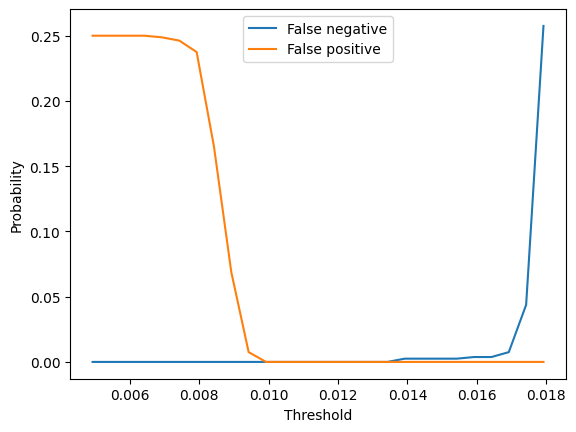

In [25]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [26]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


  0%|          | 2/800 [00:00<00:47, 16.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0092


  0%|          | 4/800 [00:00<00:45, 17.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


  1%|          | 6/800 [00:00<00:47, 16.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0079


  1%|          | 8/800 [00:00<00:47, 16.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


  1%|▏         | 10/800 [00:00<00:47, 16.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


  2%|▏         | 12/800 [00:00<00:48, 16.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


  2%|▏         | 14/800 [00:00<00:49, 15.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


  2%|▏         | 16/800 [00:00<00:49, 15.97it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0184


  2%|▏         | 18/800 [00:01<00:48, 16.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


  2%|▎         | 20/800 [00:01<00:48, 16.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0086


  3%|▎         | 22/800 [00:01<00:47, 16.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0092


  3%|▎         | 24/800 [00:01<00:46, 16.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0172


  3%|▎         | 26/800 [00:01<00:47, 16.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


  4%|▎         | 28/800 [00:01<00:47, 16.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


  4%|▍         | 30/800 [00:01<00:48, 15.83it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


  4%|▍         | 32/800 [00:01<00:46, 16.47it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


  4%|▍         | 34/800 [00:02<00:45, 16.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0018


  4%|▍         | 36/800 [00:02<00:47, 16.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


  5%|▍         | 38/800 [00:02<00:48, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


  5%|▌         | 40/800 [00:02<00:48, 15.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0087


  5%|▌         | 42/800 [00:02<00:50, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


  6%|▌         | 44/800 [00:02<00:48, 15.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


  6%|▌         | 46/800 [00:02<00:47, 15.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


  6%|▌         | 48/800 [00:02<00:47, 15.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0082


  6%|▋         | 50/800 [00:03<00:47, 15.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


  6%|▋         | 52/800 [00:03<00:49, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


  7%|▋         | 54/800 [00:03<00:47, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


  7%|▋         | 56/800 [00:03<00:46, 15.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


  7%|▋         | 58/800 [00:03<00:45, 16.47it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0176


  8%|▊         | 60/800 [00:03<00:44, 16.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


  8%|▊         | 62/800 [00:03<00:45, 16.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0017


  8%|▊         | 64/800 [00:03<00:46, 15.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


  8%|▊         | 66/800 [00:04<00:45, 16.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0086


  8%|▊         | 68/800 [00:04<00:45, 16.05it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0085


  9%|▉         | 70/800 [00:04<00:43, 16.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0173


  9%|▉         | 72/800 [00:04<00:46, 15.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


  9%|▉         | 74/800 [00:04<00:45, 15.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 10%|▉         | 76/800 [00:04<00:50, 14.46it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0012


 10%|▉         | 78/800 [00:04<00:54, 13.32it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0178


 10%|█         | 80/800 [00:05<00:55, 13.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0080


 10%|█         | 82/800 [00:05<00:56, 12.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0178


 10%|█         | 84/800 [00:05<00:57, 12.44it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0080


 11%|█         | 86/800 [00:05<00:58, 12.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 11%|█         | 88/800 [00:05<00:58, 12.11it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0177


 11%|█▏        | 90/800 [00:05<00:58, 12.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0016


 12%|█▏        | 92/800 [00:06<00:58, 12.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 12%|█▏        | 94/800 [00:06<00:57, 12.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 12%|█▏        | 96/800 [00:06<00:57, 12.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0012


 12%|█▏        | 98/800 [00:06<00:58, 12.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0090


 12%|█▎        | 100/800 [00:06<00:58, 12.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0084


 13%|█▎        | 102/800 [00:06<00:52, 13.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0088


 13%|█▎        | 104/800 [00:07<00:50, 13.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0089


 13%|█▎        | 106/800 [00:07<00:48, 14.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 14%|█▎        | 108/800 [00:07<00:46, 15.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 14%|█▍        | 110/800 [00:07<00:45, 15.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 14%|█▍        | 112/800 [00:07<00:45, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 14%|█▍        | 114/800 [00:07<00:44, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0018


 14%|█▍        | 116/800 [00:07<00:43, 15.88it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0074


 15%|█▍        | 118/800 [00:07<00:41, 16.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0018


 15%|█▌        | 120/800 [00:08<00:41, 16.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 15%|█▌        | 122/800 [00:08<00:42, 15.84it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0178


 16%|█▌        | 124/800 [00:08<00:41, 16.26it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 16%|█▌        | 126/800 [00:08<00:42, 15.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 16%|█▌        | 128/800 [00:08<00:40, 16.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0172


 16%|█▋        | 130/800 [00:08<00:41, 16.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 16%|█▋        | 132/800 [00:08<00:42, 15.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 17%|█▋        | 134/800 [00:08<00:41, 16.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


 17%|█▋        | 136/800 [00:09<00:41, 15.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0017


 17%|█▋        | 138/800 [00:09<00:43, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 18%|█▊        | 140/800 [00:09<00:43, 15.27it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0175


 18%|█▊        | 142/800 [00:09<00:42, 15.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


 18%|█▊        | 144/800 [00:09<00:45, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0081


 18%|█▊        | 146/800 [00:09<00:43, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0087


 18%|█▊        | 148/800 [00:09<00:43, 15.07it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0188


 19%|█▉        | 150/800 [00:09<00:41, 15.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 19%|█▉        | 152/800 [00:10<00:40, 15.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 19%|█▉        | 154/800 [00:10<00:41, 15.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0018


 20%|█▉        | 156/800 [00:10<00:42, 15.15it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0012


 20%|█▉        | 158/800 [00:10<00:42, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 20%|██        | 160/800 [00:10<00:40, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0081


 20%|██        | 162/800 [00:10<00:39, 16.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0018


 20%|██        | 164/800 [00:10<00:40, 15.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 21%|██        | 166/800 [00:10<00:39, 15.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0087


 21%|██        | 168/800 [00:11<00:40, 15.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0018


 21%|██▏       | 170/800 [00:11<00:40, 15.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 22%|██▏       | 172/800 [00:11<00:41, 15.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0089


 22%|██▏       | 174/800 [00:11<00:39, 15.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 22%|██▏       | 176/800 [00:11<00:39, 15.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 22%|██▏       | 178/800 [00:11<00:39, 15.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0016


 22%|██▎       | 180/800 [00:11<00:39, 15.61it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0174


 23%|██▎       | 182/800 [00:11<00:40, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 23%|██▎       | 184/800 [00:12<00:40, 15.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0078


 23%|██▎       | 186/800 [00:12<00:40, 15.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0085


 24%|██▎       | 188/800 [00:12<00:38, 15.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0175


 24%|██▍       | 190/800 [00:12<00:39, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 24%|██▍       | 192/800 [00:12<00:39, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0174


 24%|██▍       | 194/800 [00:12<00:39, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0174


 24%|██▍       | 196/800 [00:12<00:38, 15.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


 25%|██▍       | 198/800 [00:13<00:37, 15.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 25%|██▌       | 200/800 [00:13<00:38, 15.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0174


 25%|██▌       | 202/800 [00:13<00:38, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 26%|██▌       | 204/800 [00:13<00:37, 15.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 26%|██▌       | 206/800 [00:13<00:36, 16.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0167


 26%|██▌       | 208/800 [00:13<00:37, 15.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0172


 26%|██▋       | 210/800 [00:13<00:36, 16.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 26%|██▋       | 212/800 [00:13<00:35, 16.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 27%|██▋       | 214/800 [00:14<00:35, 16.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0086


 27%|██▋       | 216/800 [00:14<00:37, 15.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0176


 27%|██▋       | 218/800 [00:14<00:36, 16.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0086


 28%|██▊       | 220/800 [00:14<00:36, 16.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 28%|██▊       | 222/800 [00:14<00:35, 16.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0017


 28%|██▊       | 224/800 [00:14<00:36, 15.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 28%|██▊       | 226/800 [00:14<00:39, 14.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0092


 28%|██▊       | 228/800 [00:14<00:39, 14.46it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0012


 29%|██▉       | 230/800 [00:15<00:37, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0174


 29%|██▉       | 232/800 [00:15<00:36, 15.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 29%|██▉       | 234/800 [00:15<00:37, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0019


 30%|██▉       | 236/800 [00:15<00:37, 15.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 30%|██▉       | 238/800 [00:15<00:37, 15.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0174


 30%|███       | 240/800 [00:15<00:35, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 30%|███       | 242/800 [00:15<00:35, 15.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0081


 30%|███       | 244/800 [00:15<00:35, 15.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0083


 31%|███       | 246/800 [00:16<00:34, 16.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 31%|███       | 248/800 [00:16<00:35, 15.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 31%|███▏      | 250/800 [00:16<00:36, 15.27it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 32%|███▏      | 252/800 [00:16<00:36, 15.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 32%|███▏      | 254/800 [00:16<00:36, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 32%|███▏      | 256/800 [00:16<00:35, 15.26it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0177


 32%|███▏      | 258/800 [00:16<00:39, 13.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0088


 32%|███▎      | 260/800 [00:17<00:43, 12.39it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0086


 33%|███▎      | 262/800 [00:17<00:44, 11.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0082


 33%|███▎      | 264/800 [00:17<00:45, 11.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0184


 33%|███▎      | 266/800 [00:17<00:45, 11.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 34%|███▎      | 268/800 [00:17<00:45, 11.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 34%|███▍      | 270/800 [00:18<00:45, 11.60it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0186


 34%|███▍      | 272/800 [00:18<00:47, 11.14it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0078


 34%|███▍      | 274/800 [00:18<00:46, 11.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0016


 34%|███▍      | 276/800 [00:18<00:46, 11.31it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0178


 35%|███▍      | 278/800 [00:18<00:47, 10.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0175


 35%|███▌      | 280/800 [00:18<00:47, 10.86it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0180


 35%|███▌      | 282/800 [00:19<00:46, 11.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 36%|███▌      | 284/800 [00:19<00:43, 11.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 36%|███▌      | 286/800 [00:19<00:40, 12.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 36%|███▌      | 288/800 [00:19<00:38, 13.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 36%|███▋      | 290/800 [00:19<00:38, 13.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0087


 36%|███▋      | 292/800 [00:19<00:36, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 37%|███▋      | 294/800 [00:19<00:35, 14.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 37%|███▋      | 296/800 [00:20<00:34, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 37%|███▋      | 298/800 [00:20<00:33, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 38%|███▊      | 300/800 [00:20<00:33, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 38%|███▊      | 302/800 [00:20<00:33, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 38%|███▊      | 304/800 [00:20<00:33, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 38%|███▊      | 306/800 [00:20<00:32, 15.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 38%|███▊      | 308/800 [00:20<00:33, 14.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 39%|███▉      | 310/800 [00:20<00:32, 15.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 39%|███▉      | 312/800 [00:21<00:33, 14.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 39%|███▉      | 314/800 [00:21<00:32, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 40%|███▉      | 316/800 [00:21<00:32, 14.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0012


 40%|███▉      | 318/800 [00:21<00:33, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 40%|████      | 320/800 [00:21<00:33, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 40%|████      | 322/800 [00:21<00:32, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 40%|████      | 324/800 [00:21<00:31, 15.05it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0176


 41%|████      | 326/800 [00:22<00:30, 15.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 41%|████      | 328/800 [00:22<00:30, 15.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0017


 41%|████▏     | 330/800 [00:22<00:31, 15.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 42%|████▏     | 332/800 [00:22<00:31, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0017


 42%|████▏     | 334/800 [00:22<00:30, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 42%|████▏     | 336/800 [00:22<00:30, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0067


 42%|████▏     | 338/800 [00:22<00:30, 15.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 42%|████▎     | 340/800 [00:22<00:30, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


 43%|████▎     | 342/800 [00:23<00:30, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0091


 43%|████▎     | 344/800 [00:23<00:30, 15.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0083


 43%|████▎     | 346/800 [00:23<00:31, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0085


 44%|████▎     | 348/800 [00:23<00:31, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 44%|████▍     | 350/800 [00:23<00:31, 14.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0094


 44%|████▍     | 352/800 [00:23<00:30, 14.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 44%|████▍     | 354/800 [00:23<00:30, 14.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


 44%|████▍     | 356/800 [00:24<00:29, 14.89it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0180


 45%|████▍     | 358/800 [00:24<00:29, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 45%|████▌     | 360/800 [00:24<00:29, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 45%|████▌     | 362/800 [00:24<00:29, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 46%|████▌     | 364/800 [00:24<00:28, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 46%|████▌     | 366/800 [00:24<00:28, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0082


 46%|████▌     | 368/800 [00:24<00:28, 15.24it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0087


 46%|████▋     | 370/800 [00:24<00:28, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 46%|████▋     | 372/800 [00:25<00:28, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 47%|████▋     | 374/800 [00:25<00:28, 15.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 47%|████▋     | 376/800 [00:25<00:28, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 47%|████▋     | 378/800 [00:25<00:28, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 48%|████▊     | 380/800 [00:25<00:28, 14.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 48%|████▊     | 382/800 [00:25<00:27, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0090


 48%|████▊     | 384/800 [00:25<00:27, 15.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0172


 48%|████▊     | 386/800 [00:26<00:27, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 48%|████▊     | 388/800 [00:26<00:26, 15.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 49%|████▉     | 390/800 [00:26<00:26, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 49%|████▉     | 392/800 [00:26<00:26, 15.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


 49%|████▉     | 394/800 [00:26<00:26, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0084


 50%|████▉     | 396/800 [00:26<00:25, 15.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0175


 50%|████▉     | 398/800 [00:26<00:26, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 50%|█████     | 400/800 [00:26<00:26, 15.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0084


 50%|█████     | 402/800 [00:27<00:25, 15.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 50%|█████     | 404/800 [00:27<00:25, 15.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0174


 51%|█████     | 406/800 [00:27<00:26, 15.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 51%|█████     | 408/800 [00:27<00:25, 15.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0091


 51%|█████▏    | 410/800 [00:27<00:25, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 52%|█████▏    | 412/800 [00:27<00:25, 15.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0085


 52%|█████▏    | 414/800 [00:27<00:24, 15.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 52%|█████▏    | 416/800 [00:28<00:24, 15.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 52%|█████▏    | 418/800 [00:28<00:25, 15.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 52%|█████▎    | 420/800 [00:28<00:24, 15.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 53%|█████▎    | 422/800 [00:28<00:24, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 53%|█████▎    | 424/800 [00:28<00:24, 15.36it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0182


 53%|█████▎    | 426/800 [00:28<00:24, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0081


 54%|█████▎    | 428/800 [00:28<00:24, 15.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0094


 54%|█████▍    | 430/800 [00:28<00:23, 15.83it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 54%|█████▍    | 432/800 [00:29<00:23, 15.43it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0092


 54%|█████▍    | 434/800 [00:29<00:24, 14.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 55%|█████▍    | 436/800 [00:29<00:26, 13.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0182


 55%|█████▍    | 438/800 [00:29<00:27, 12.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0017


 55%|█████▌    | 440/800 [00:29<00:28, 12.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 55%|█████▌    | 442/800 [00:29<00:28, 12.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 56%|█████▌    | 444/800 [00:30<00:28, 12.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0082


 56%|█████▌    | 446/800 [00:30<00:29, 12.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0016


 56%|█████▌    | 448/800 [00:30<00:28, 12.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0084


 56%|█████▋    | 450/800 [00:30<00:29, 11.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0085


 56%|█████▋    | 452/800 [00:30<00:29, 11.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0080


 57%|█████▋    | 454/800 [00:30<00:29, 11.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 57%|█████▋    | 456/800 [00:31<00:30, 11.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0178


 57%|█████▋    | 458/800 [00:31<00:30, 11.38it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0181


 57%|█████▊    | 460/800 [00:31<00:30, 11.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 58%|█████▊    | 462/800 [00:31<00:28, 12.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 58%|█████▊    | 464/800 [00:31<00:25, 12.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 58%|█████▊    | 466/800 [00:31<00:24, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 58%|█████▊    | 468/800 [00:31<00:23, 14.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0087


 59%|█████▉    | 470/800 [00:32<00:22, 14.41it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0171


 59%|█████▉    | 472/800 [00:32<00:22, 14.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 59%|█████▉    | 474/800 [00:32<00:21, 14.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0085


 60%|█████▉    | 476/800 [00:32<00:22, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0017


 60%|█████▉    | 478/800 [00:32<00:21, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 60%|██████    | 480/800 [00:32<00:21, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 60%|██████    | 482/800 [00:32<00:20, 15.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 60%|██████    | 484/800 [00:33<00:20, 15.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0087


 61%|██████    | 486/800 [00:33<00:20, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 61%|██████    | 488/800 [00:33<00:20, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 61%|██████▏   | 490/800 [00:33<00:20, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0082


 62%|██████▏   | 492/800 [00:33<00:20, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0089


 62%|██████▏   | 494/800 [00:33<00:20, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0176


 62%|██████▏   | 496/800 [00:33<00:19, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 62%|██████▏   | 498/800 [00:33<00:19, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 62%|██████▎   | 500/800 [00:34<00:19, 15.21it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0182


 63%|██████▎   | 502/800 [00:34<00:19, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 63%|██████▎   | 504/800 [00:34<00:19, 15.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 63%|██████▎   | 506/800 [00:34<00:18, 15.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0086


 64%|██████▎   | 508/800 [00:34<00:19, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0017


 64%|██████▍   | 510/800 [00:34<00:19, 15.06it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0188


 64%|██████▍   | 512/800 [00:34<00:18, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 64%|██████▍   | 514/800 [00:34<00:18, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 64%|██████▍   | 516/800 [00:35<00:18, 15.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0078


 65%|██████▍   | 518/800 [00:35<00:19, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 65%|██████▌   | 520/800 [00:35<00:19, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


 65%|██████▌   | 522/800 [00:35<00:18, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 66%|██████▌   | 524/800 [00:35<00:18, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0083


 66%|██████▌   | 526/800 [00:35<00:18, 15.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0090


 66%|██████▌   | 528/800 [00:35<00:18, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0087


 66%|██████▋   | 530/800 [00:36<00:17, 15.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0172


 66%|██████▋   | 532/800 [00:36<00:17, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 67%|██████▋   | 534/800 [00:36<00:16, 15.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 67%|██████▋   | 536/800 [00:36<00:17, 15.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0084


 67%|██████▋   | 538/800 [00:36<00:17, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0172


 68%|██████▊   | 540/800 [00:36<00:16, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 68%|██████▊   | 542/800 [00:36<00:16, 15.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0096


 68%|██████▊   | 544/800 [00:36<00:16, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0012


 68%|██████▊   | 546/800 [00:37<00:16, 15.01it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0080


 68%|██████▊   | 548/800 [00:37<00:16, 15.15it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0089


 69%|██████▉   | 550/800 [00:37<00:16, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0091


 69%|██████▉   | 552/800 [00:37<00:16, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0175


 69%|██████▉   | 554/800 [00:37<00:16, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0085


 70%|██████▉   | 556/800 [00:37<00:17, 14.32it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0017


 70%|██████▉   | 558/800 [00:37<00:16, 14.83it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 70%|███████   | 560/800 [00:38<00:15, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 70%|███████   | 562/800 [00:38<00:15, 14.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0090


 70%|███████   | 564/800 [00:38<00:15, 14.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 71%|███████   | 566/800 [00:38<00:15, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0018


 71%|███████   | 568/800 [00:38<00:15, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 71%|███████▏  | 570/800 [00:38<00:15, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0012


 72%|███████▏  | 572/800 [00:38<00:15, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 72%|███████▏  | 574/800 [00:39<00:15, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 72%|███████▏  | 576/800 [00:39<00:15, 14.87it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0158


 72%|███████▏  | 578/800 [00:39<00:14, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 72%|███████▎  | 580/800 [00:39<00:14, 15.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 73%|███████▎  | 582/800 [00:39<00:14, 15.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 73%|███████▎  | 584/800 [00:39<00:14, 14.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 73%|███████▎  | 586/800 [00:39<00:14, 14.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0083


 74%|███████▎  | 588/800 [00:39<00:14, 14.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0177


 74%|███████▍  | 590/800 [00:40<00:24,  8.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0093


 74%|███████▍  | 592/800 [00:40<00:21,  9.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 74%|███████▍  | 594/800 [00:40<00:19, 10.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 74%|███████▍  | 596/800 [00:40<00:18, 11.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0017


 75%|███████▍  | 598/800 [00:40<00:16, 11.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0012


 75%|███████▌  | 600/800 [00:41<00:16, 12.40it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0012


 75%|███████▌  | 602/800 [00:41<00:15, 12.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0089


 76%|███████▌  | 604/800 [00:41<00:15, 12.80it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0087


 76%|███████▌  | 606/800 [00:41<00:16, 12.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0178


 76%|███████▌  | 608/800 [00:41<00:17, 11.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0017


 76%|███████▋  | 610/800 [00:42<00:17, 11.04it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0082


 76%|███████▋  | 612/800 [00:42<00:17, 11.02it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0178


 77%|███████▋  | 614/800 [00:42<00:17, 10.79it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0182


 77%|███████▋  | 616/800 [00:42<00:16, 10.94it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0012


 77%|███████▋  | 618/800 [00:42<00:17, 10.55it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0175


 78%|███████▊  | 620/800 [00:42<00:17, 10.49it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0183


 78%|███████▊  | 622/800 [00:43<00:17, 10.28it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0087


 78%|███████▊  | 624/800 [00:43<00:16, 10.39it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0012


 78%|███████▊  | 626/800 [00:43<00:17, 10.07it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0185


 78%|███████▊  | 628/800 [00:43<00:17, 10.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 79%|███████▉  | 630/800 [00:43<00:17,  9.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0091


 79%|███████▉  | 632/800 [00:44<00:15, 10.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 79%|███████▉  | 634/800 [00:44<00:14, 11.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0085


 80%|███████▉  | 636/800 [00:44<00:13, 12.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0084


 80%|███████▉  | 638/800 [00:44<00:13, 12.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0173


 80%|████████  | 640/800 [00:44<00:12, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


 80%|████████  | 642/800 [00:44<00:11, 13.42it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0177


 80%|████████  | 644/800 [00:44<00:11, 13.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 81%|████████  | 646/800 [00:45<00:11, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0012


 81%|████████  | 648/800 [00:45<00:11, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0173


 81%|████████▏ | 650/800 [00:45<00:10, 13.88it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0188


 82%|████████▏ | 652/800 [00:45<00:10, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0082


 82%|████████▏ | 654/800 [00:45<00:10, 13.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 82%|████████▏ | 656/800 [00:45<00:10, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0172


 82%|████████▏ | 658/800 [00:46<00:10, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 82%|████████▎ | 660/800 [00:46<00:09, 14.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 83%|████████▎ | 662/800 [00:46<00:09, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 83%|████████▎ | 664/800 [00:46<00:09, 13.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0137


 83%|████████▎ | 666/800 [00:46<00:09, 13.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0089


 84%|████████▎ | 668/800 [00:46<00:09, 14.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0018


 84%|████████▍ | 670/800 [00:46<00:09, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0080


 84%|████████▍ | 672/800 [00:47<00:09, 14.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 84%|████████▍ | 674/800 [00:47<00:08, 14.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0017


 84%|████████▍ | 676/800 [00:47<00:08, 14.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0083


 85%|████████▍ | 678/800 [00:47<00:08, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0089


 85%|████████▌ | 680/800 [00:47<00:08, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 85%|████████▌ | 682/800 [00:47<00:07, 14.90it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0081


 86%|████████▌ | 684/800 [00:47<00:07, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0017


 86%|████████▌ | 686/800 [00:47<00:07, 14.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


 86%|████████▌ | 688/800 [00:48<00:07, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0083


 86%|████████▋ | 690/800 [00:48<00:07, 14.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0017


 86%|████████▋ | 692/800 [00:48<00:07, 14.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0085


 87%|████████▋ | 694/800 [00:48<00:07, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0090


 87%|████████▋ | 696/800 [00:48<00:07, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 87%|████████▋ | 698/800 [00:48<00:07, 14.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 88%|████████▊ | 700/800 [00:48<00:06, 14.62it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0171


 88%|████████▊ | 702/800 [00:49<00:06, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 88%|████████▊ | 704/800 [00:49<00:06, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 88%|████████▊ | 706/800 [00:49<00:06, 14.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0177


 88%|████████▊ | 708/800 [00:49<00:06, 14.46it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0089


 89%|████████▉ | 710/800 [00:49<00:06, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0012


 89%|████████▉ | 712/800 [00:49<00:05, 15.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 89%|████████▉ | 714/800 [00:49<00:05, 15.03it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0177


 90%|████████▉ | 716/800 [00:49<00:05, 14.74it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0012


 90%|████████▉ | 718/800 [00:50<00:05, 14.96it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0172


 90%|█████████ | 720/800 [00:50<00:05, 14.96it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0179


 90%|█████████ | 722/800 [00:50<00:05, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 90%|█████████ | 724/800 [00:50<00:05, 14.89it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0084


 91%|█████████ | 726/800 [00:50<00:04, 15.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0012


 91%|█████████ | 728/800 [00:50<00:04, 14.97it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0085


 91%|█████████▏| 730/800 [00:50<00:04, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0175


 92%|█████████▏| 732/800 [00:51<00:04, 15.51it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0177


 92%|█████████▏| 734/800 [00:51<00:04, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0017


 92%|█████████▏| 736/800 [00:51<00:04, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 92%|█████████▏| 738/800 [00:51<00:04, 15.45it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0086


 92%|█████████▎| 740/800 [00:51<00:03, 15.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 93%|█████████▎| 742/800 [00:51<00:03, 15.10it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0176


 93%|█████████▎| 744/800 [00:51<00:03, 15.54it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0178


 93%|█████████▎| 746/800 [00:51<00:03, 15.51it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0085


 94%|█████████▎| 748/800 [00:52<00:03, 15.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 94%|█████████▍| 750/800 [00:52<00:03, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 94%|█████████▍| 752/800 [00:52<00:03, 15.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0092


 94%|█████████▍| 754/800 [00:52<00:03, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 94%|█████████▍| 756/800 [00:52<00:02, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 95%|█████████▍| 758/800 [00:52<00:02, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0086


 95%|█████████▌| 760/800 [00:52<00:02, 14.86it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0178


 95%|█████████▌| 762/800 [00:52<00:02, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 96%|█████████▌| 764/800 [00:53<00:02, 15.10it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0173


 96%|█████████▌| 766/800 [00:53<00:02, 15.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 96%|█████████▌| 768/800 [00:53<00:02, 14.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0012


 96%|█████████▋| 770/800 [00:53<00:02, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 96%|█████████▋| 772/800 [00:53<00:01, 14.88it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0017


 97%|█████████▋| 774/800 [00:53<00:01, 14.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0085


 97%|█████████▋| 776/800 [00:53<00:01, 14.38it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0012


 97%|█████████▋| 778/800 [00:54<00:01, 12.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 98%|█████████▊| 780/800 [00:54<00:01, 12.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 98%|█████████▊| 782/800 [00:54<00:01, 12.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 98%|█████████▊| 784/800 [00:54<00:01, 12.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0082


 98%|█████████▊| 786/800 [00:54<00:01, 11.92it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0176


 98%|█████████▊| 788/800 [00:55<00:01, 11.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0012


 99%|█████████▉| 790/800 [00:55<00:00, 11.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0012


 99%|█████████▉| 792/800 [00:55<00:00, 11.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0178


 99%|█████████▉| 794/800 [00:55<00:00, 11.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0018


100%|█████████▉| 796/800 [00:55<00:00, 11.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


100%|█████████▉| 798/800 [00:55<00:00, 10.55it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0181


100%|██████████| 800/800 [00:56<00:00, 14.24it/s]


In [27]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of this predictor

The overall accuracy of the predictor is: 87.375 %


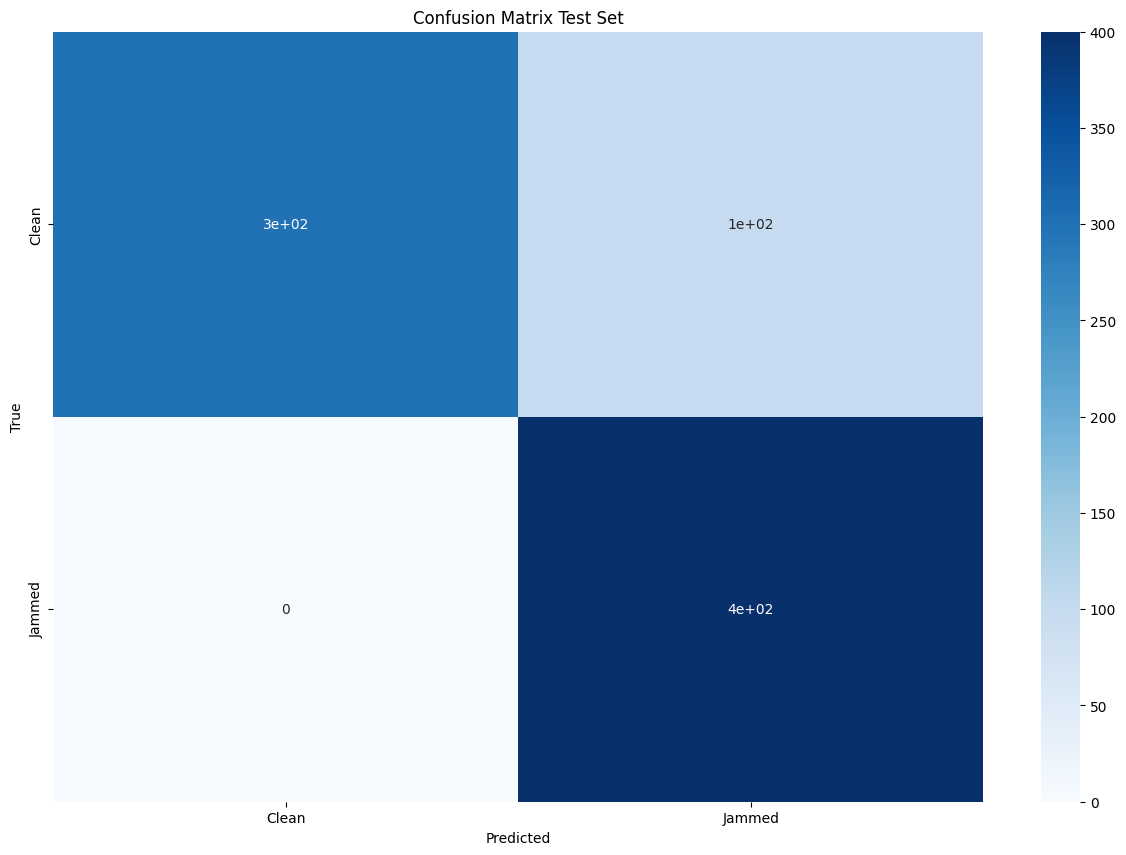

In [28]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold